In [1]:
# Import the function from the path_setup module
from path_setup import add_project_root_to_path

# Call the function to add the project root to the Python path
add_project_root_to_path()

Project root added to sys.path: /Users/jan-hendrikwitte/Documents/Arbeit/code/monitoiring_pipeline


In [2]:
from pipeline.utils.path_manager import PathManager
from pipeline.utils.data_analysis_utils import sorting_key, load_monitoring_pipeline_results

path_manager = PathManager()

path_to_config_files = path_manager.path_to_config_files
path_to_piglet_rearing_info = path_manager.path_to_piglet_rearing_info
path_to_pipeline_outputs = path_manager.path_to_monitoring_pipeline_outputs
path_to_result_data_aggregations = path_manager.path_to_pipeline_results_aggregations

In [3]:
# load data
pipeline_monitoring_results = load_monitoring_pipeline_results(
    path_to_pipeline_outputs, path_to_config_files)

# Sort the monitoring_results by pen number and then by start date

pipeline_monitoring_results.sort(key=sorting_key)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from pipeline.utils.general import load_label_file, load_json_data
from pipeline.utils.path_manager import PathManager
from pipeline.utils.data_analysis_utils import format_datespan, get_pen_info
from pipeline.utils.visualization import plot_culprit_removal_dates, shade_pre_outbreak_period


def analyze_activity_changes(monitoring_result, json_path, ax=None, resample_freq="D", normalize=True, add_labels=True, rolling_window=None, fix_y_axis_max=False, save_path=None):
    """
    Plots the difference in monitored tail postures over specified intervals for a single monitoring result. The function
    handles data normalization, applies a rolling average if specified, and performs linear interpolation on the data.
    It also colors areas under the curve based on significant events related to tail biting, including pre-outbreak periods
    as indicated by the culprit removal dates, if provided. The plot visually represents the change in tail posture behaviors
    over time, highlighting critical pre-outbreak intervals (based on Larhmann et al. 2018).

    Parameters:
    - monitoring_result (dict): Contains camera, date_span, data_paths, and dataframes with tail posture data.
    - json_path (str): Path to the JSON file with metadata to determine pen type, culprit removal date as well as ground truth datespansee.
    - resample_freq (str): Frequency for data resampling (default is "D" for daily).
    - normalize (bool): If True, normalizes the tail posture data before plotting.
    - rolling_window (int or None): Specifies the window size for rolling average calculation. If None, no rolling average is applied.
    - fix_y_axis_max (bool): If True, fixes the y-axis maximum value to 1.
    - save_path (str or None): If specified, saves the generated plot to the given path.

    Returns:
    None. A plot is displayed showing the tail posture difference over time, with additional visual cues for significant periods.
    """

    # If no axes are provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 6))

    subtitle_fontsize = 12  # Adjust font size for subtitles
    axis_label_fontsize = 11  # Adjust font size for axis labels
    ticks_fontsize = 11  # Adjust font size for axis ticks

    # Load JSON data from the file
    json_data = load_json_data(json_path)

    # Extracting pen info
    pen_type, culprit_removal, datespan_gt = get_pen_info(
        monitoring_result['camera'], monitoring_result['date_span'], json_data)

    camera_label = monitoring_result['camera'].replace("Kamera", "Pen ")
    formatted_datespan = format_datespan(monitoring_result['date_span'])
    formatted_datespan_gt = format_datespan(datespan_gt)

    # Concatenate dataframes from the dictionary
    data_all = pd.concat(monitoring_result['dataframes'])

    # Create a copy and set datetime index
    data_all_copy = data_all.copy()
    data_all_copy["datetime"] = pd.to_datetime(data_all_copy["datetime"])
    data_all_copy.set_index("datetime", inplace=True)

    avg_data = data_all_copy.resample(resample_freq).mean()

    # Apply rolling/moving average if specified
    if rolling_window:
        avg_data = avg_data.rolling(window=rolling_window).mean()

    # Normalize if the option is set
    if normalize:
        avg_data['activity'] = (avg_data['activity'] - avg_data['activity'].min()) / (
            avg_data['activity'].max() - avg_data['activity'].min())

    # Perform interpolation
    interpolated_data = avg_data.resample("H").interpolate(method='linear')

    ax.plot(interpolated_data.index, interpolated_data['activity'],
            label='Activity', color="black", linewidth=2)

    ax.fill_between(interpolated_data.index, interpolated_data['activity'], 0,
                    where=(interpolated_data['activity'] >= 0), color="grey", alpha=0.1)

    # Check if the pen type is "tail biting"
    if pen_type == "tail biting":
        plot_culprit_removal_dates(interpolated_data, culprit_removal, ax)

    # shade the pre-outbreak period if the pen type is "tail biting" and culprit_removal is specified
    if pen_type == "tail biting" and culprit_removal is not None:
        # 7 days pre outbreak (Lahrmann et al. 2018)
        shade_pre_outbreak_period(
            interpolated_data, culprit_removal, 7, ax, color="orange", alpha=0.2)
        # 3 days pre outbreak (Lahrmann et al. 2018)
        shade_pre_outbreak_period(
            interpolated_data, culprit_removal, 3, ax, color="red", alpha=0.2)

    ax.set_title(f"{camera_label} | {pen_type} | Full Timespan: {formatted_datespan_gt} | Analyzed Timespan: {formatted_datespan}",
                 fontsize=subtitle_fontsize)

    if add_labels:
        ax.set_xlabel('Date', fontsize=axis_label_fontsize)
        ax.set_ylabel('Acticity', fontsize=axis_label_fontsize)

    # Check if the y-axis max should be fixed
    if fix_y_axis_max:
        ax.set_ylim(top=0.95)  # Set the maximum y-axis value to 1

    ax.tick_params(axis='x', labelrotation=45)
    ax.tick_params(axis='both', which='major', labelsize=ticks_fontsize)

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    # Remove plt.show() if ax is provided; it will be handled externally
    if ax is None:
        plt.show()

/var/folders/18/v2wpw9qn0lq00p_4wj56fh1h0000gn/T/ipykernel_67792/2846514963.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(18, 6))


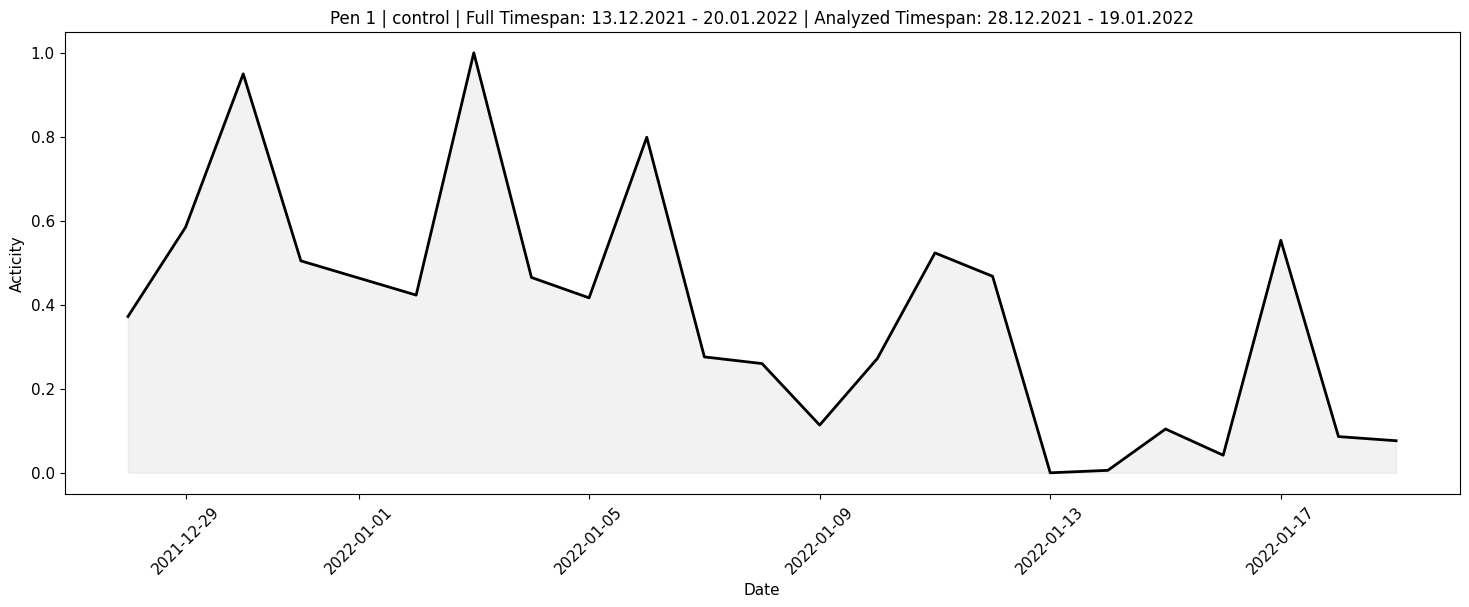

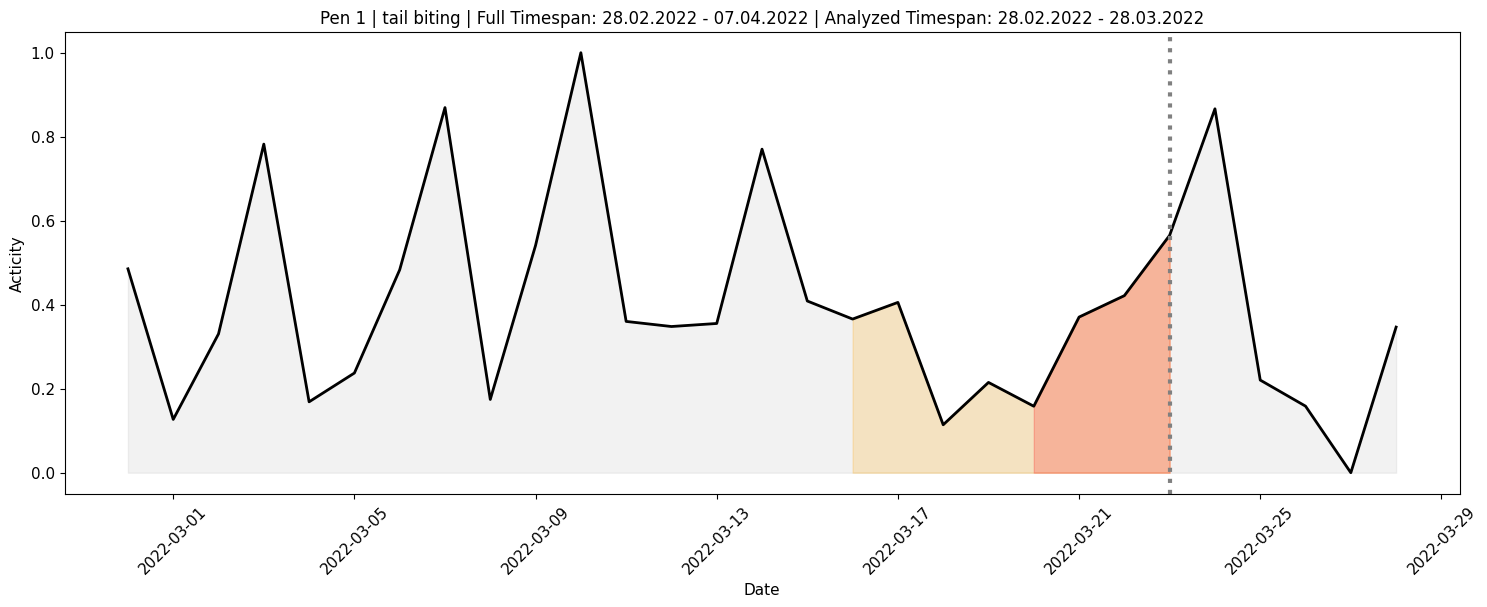

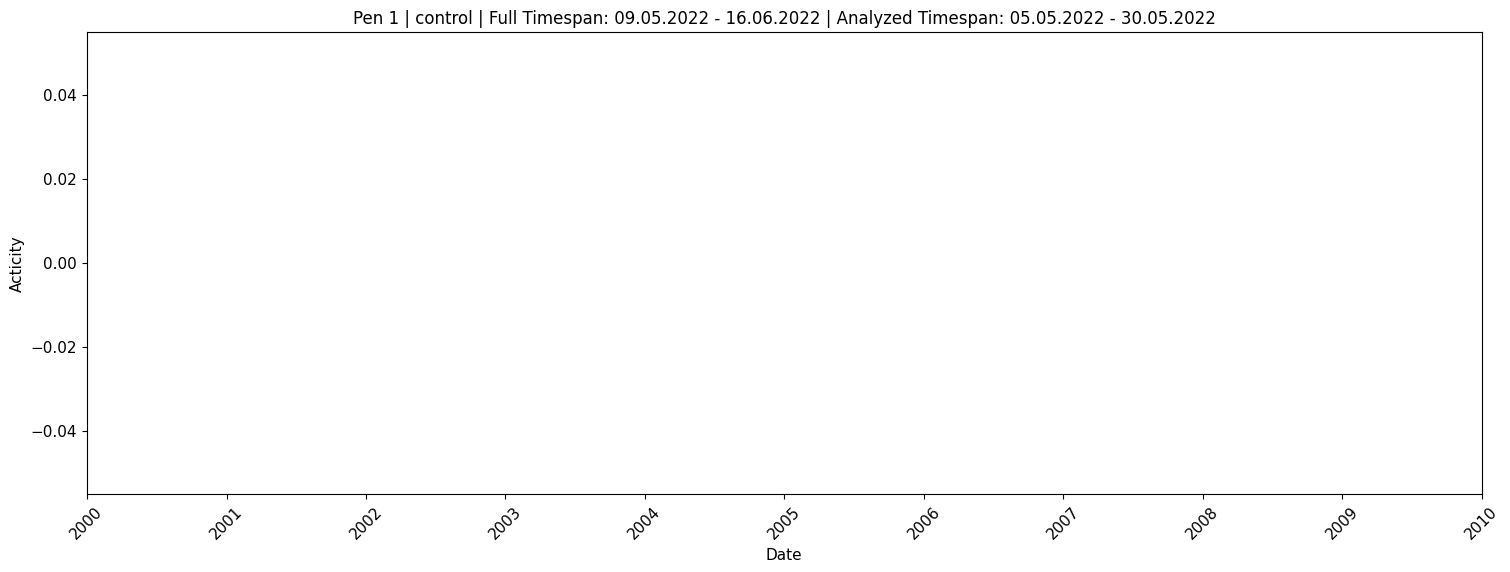

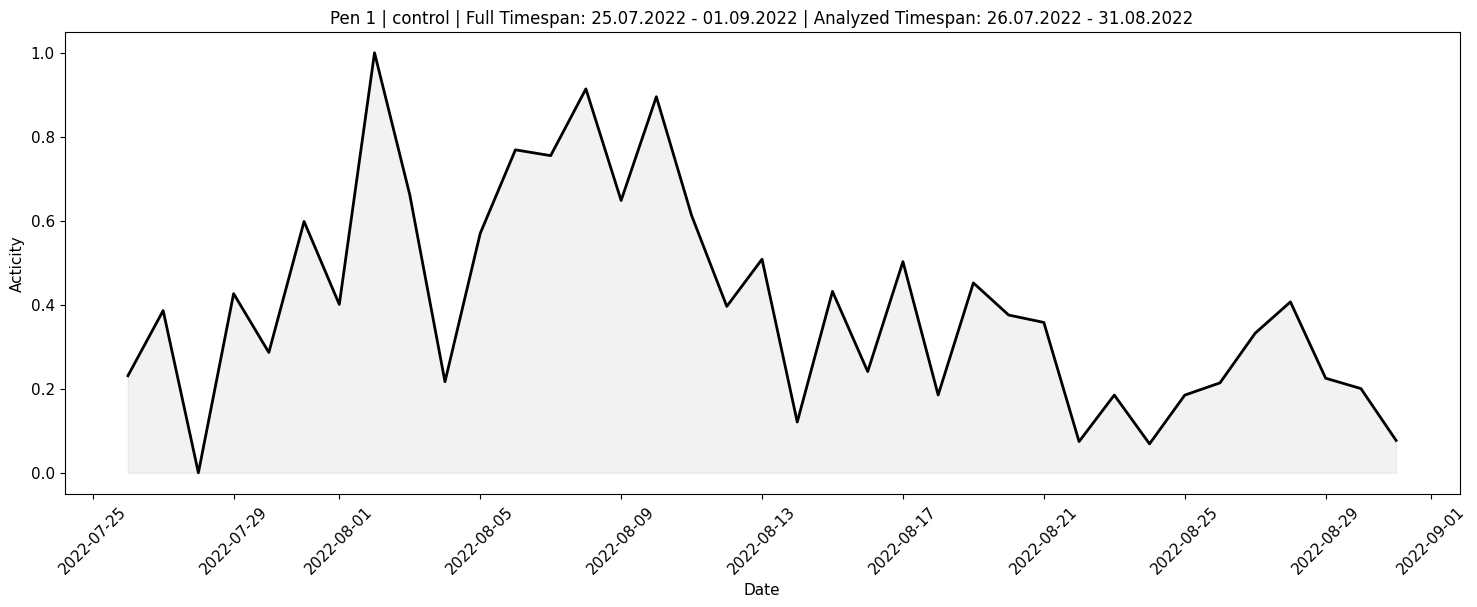

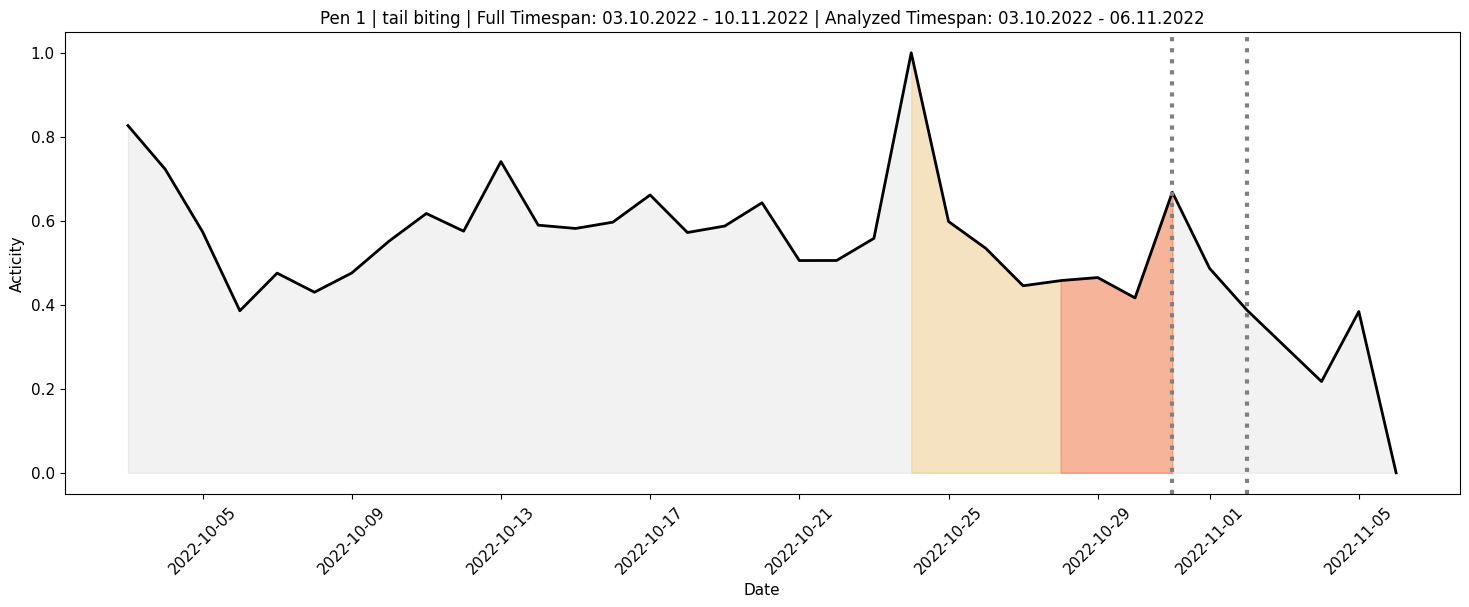

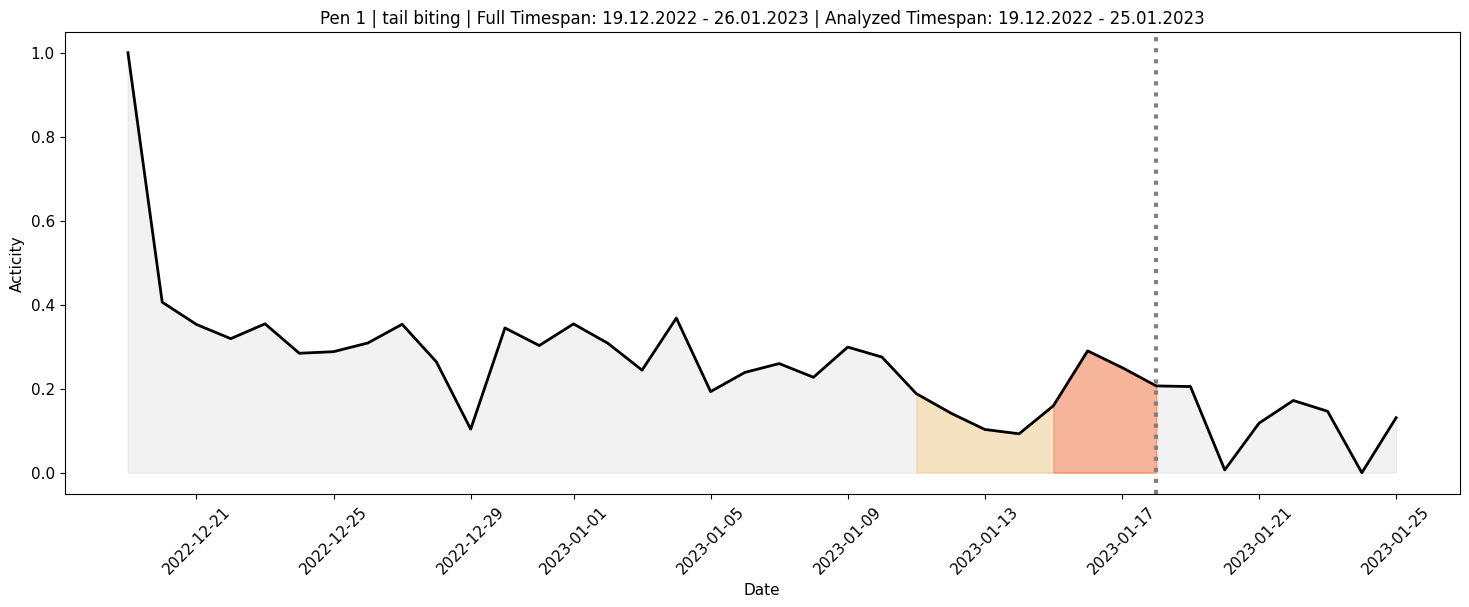

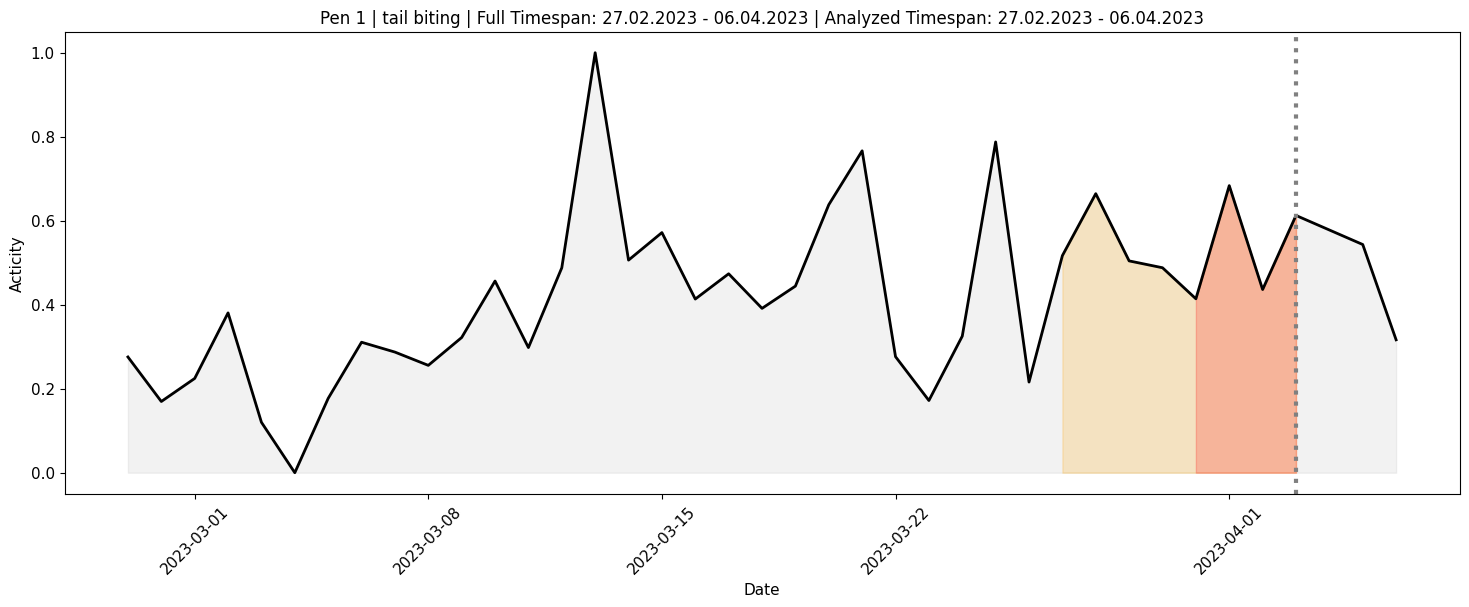

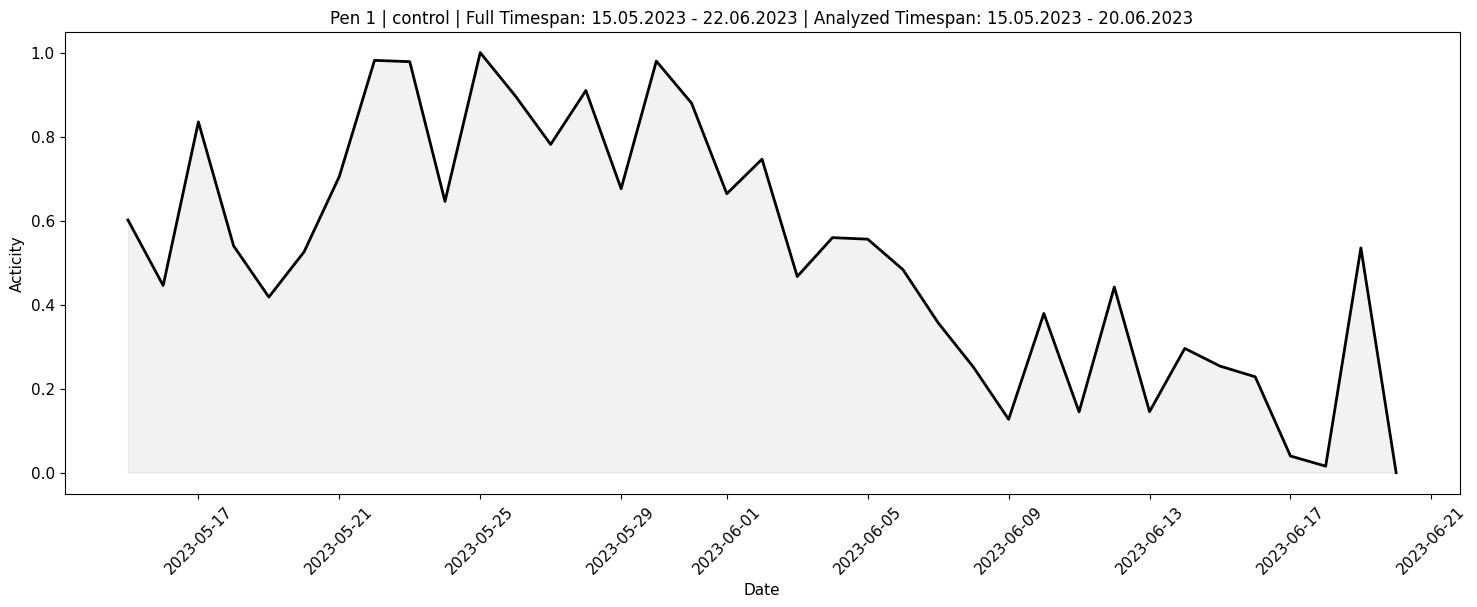

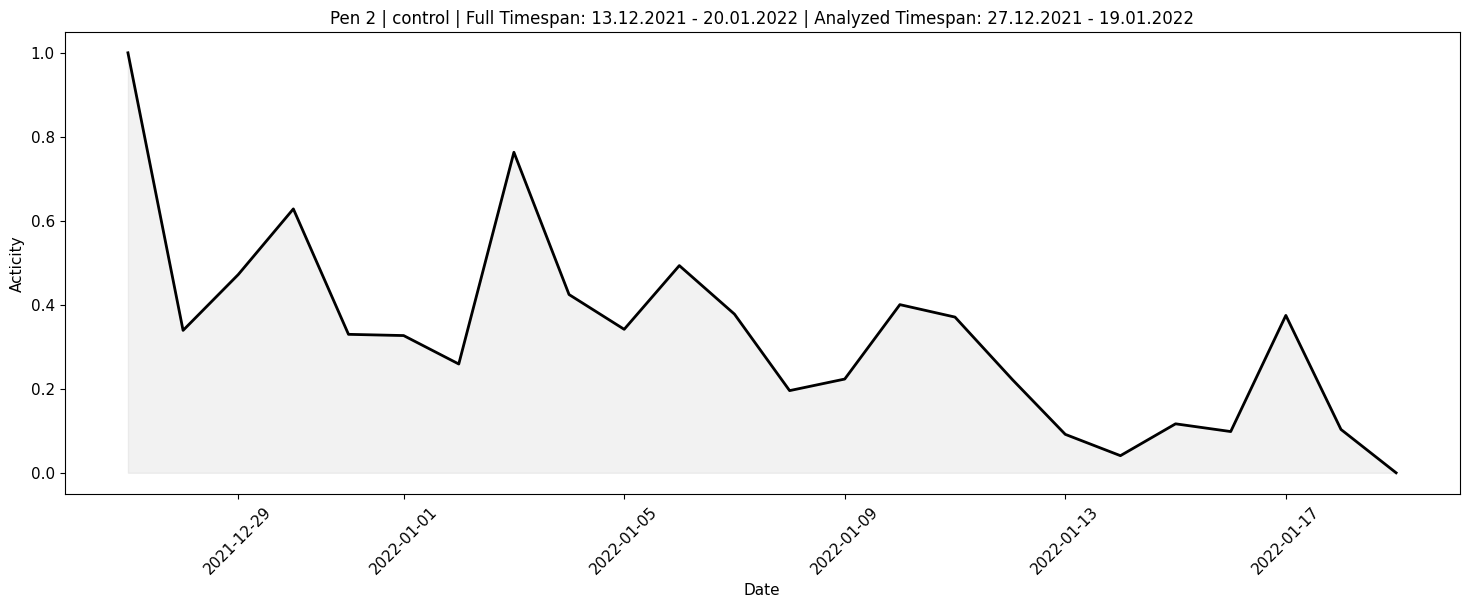

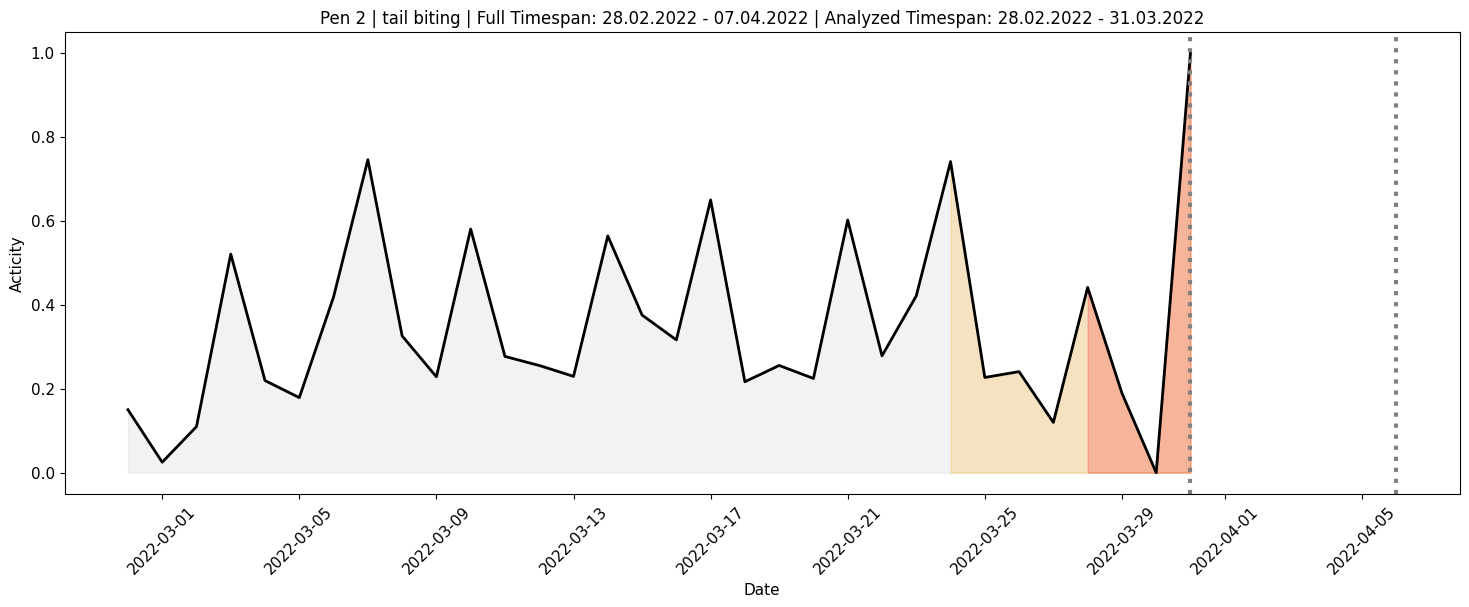

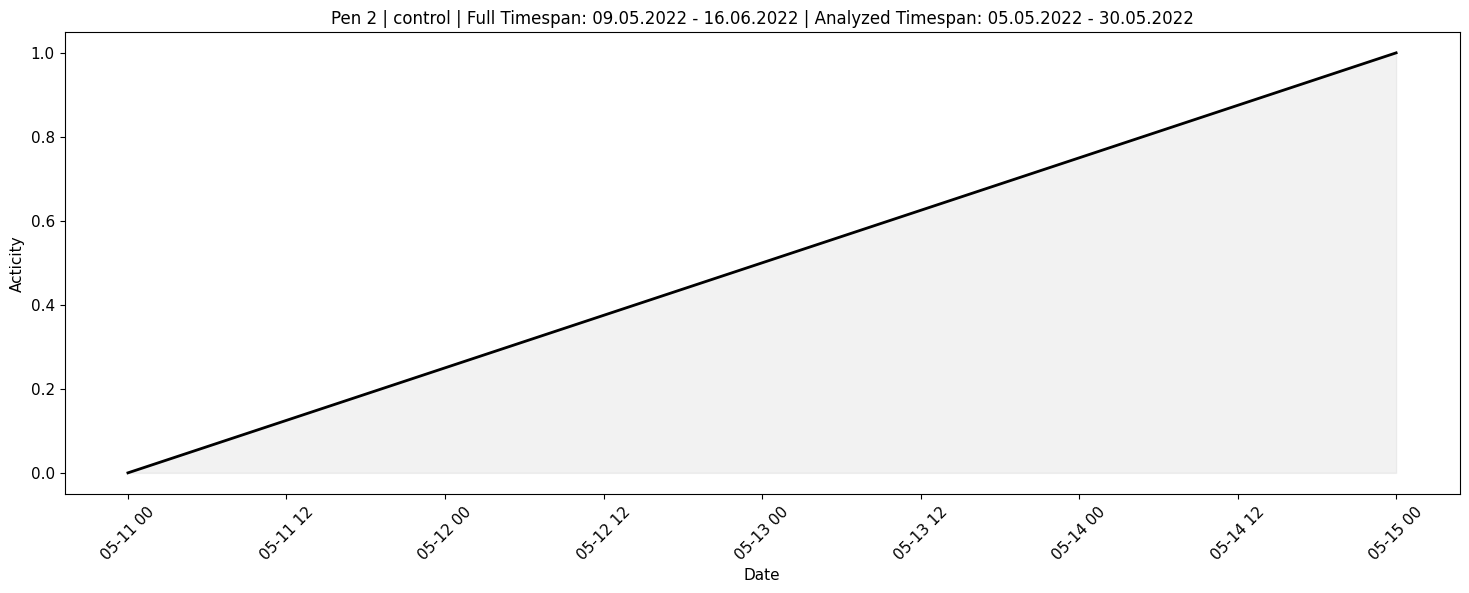

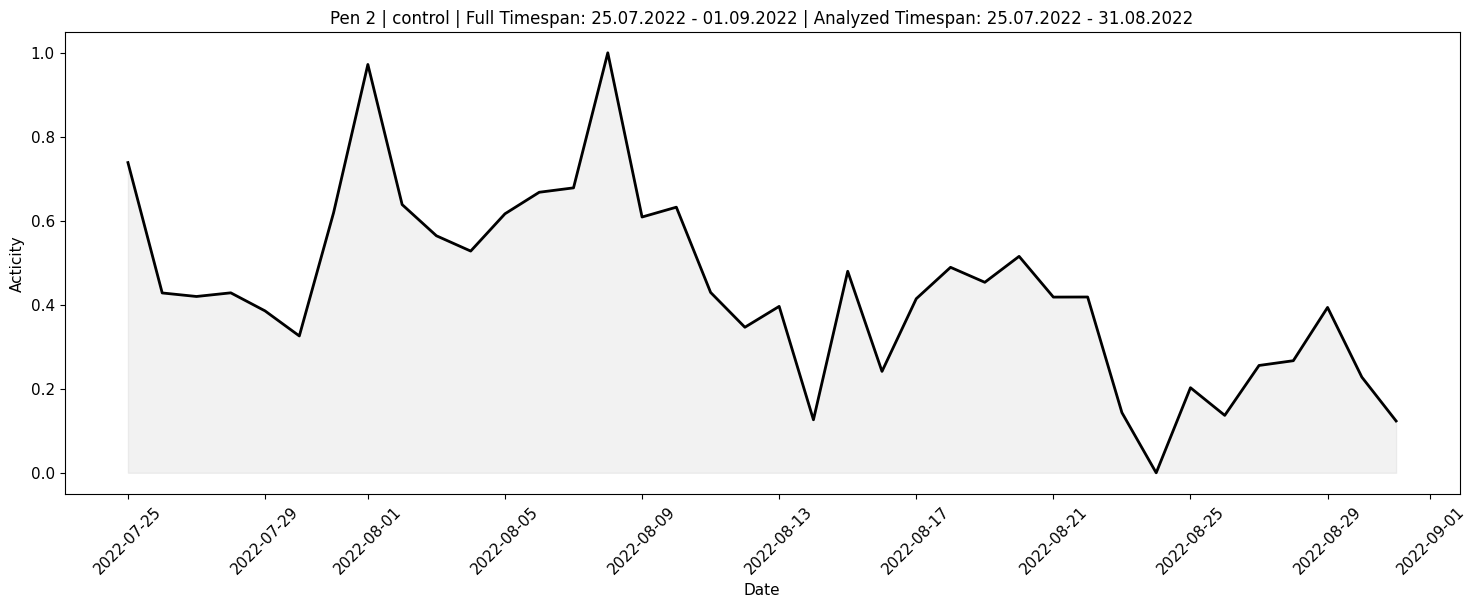

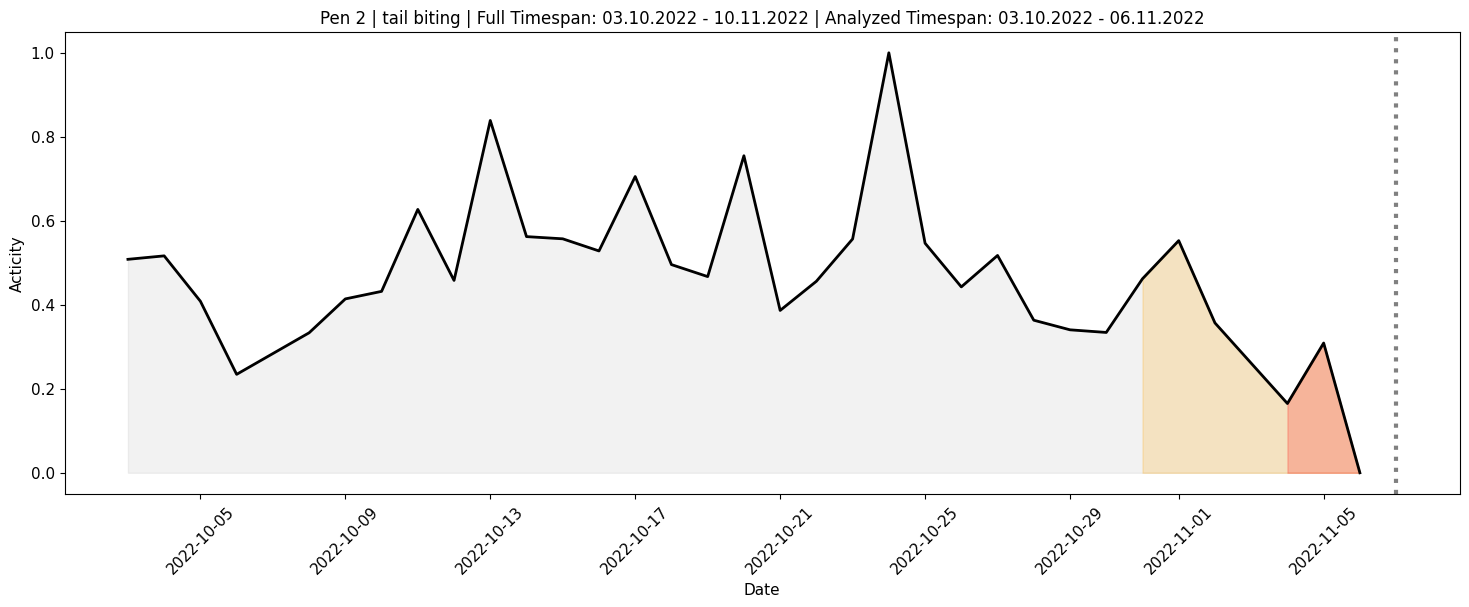

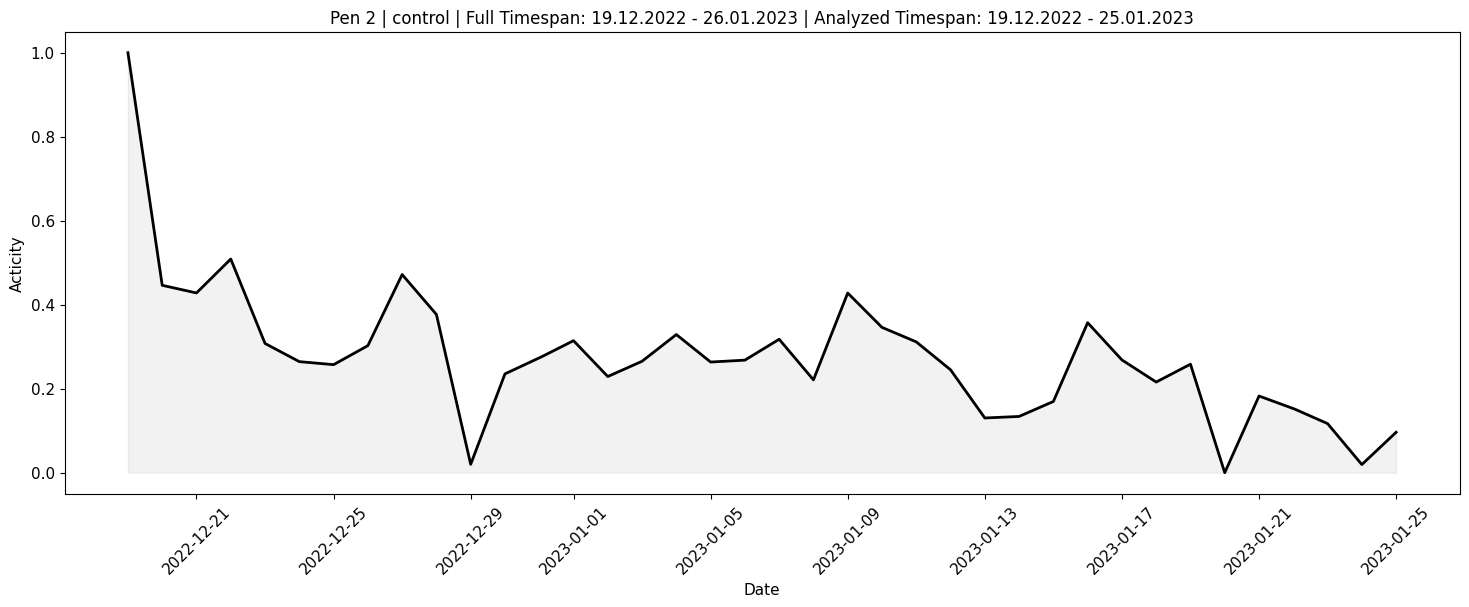

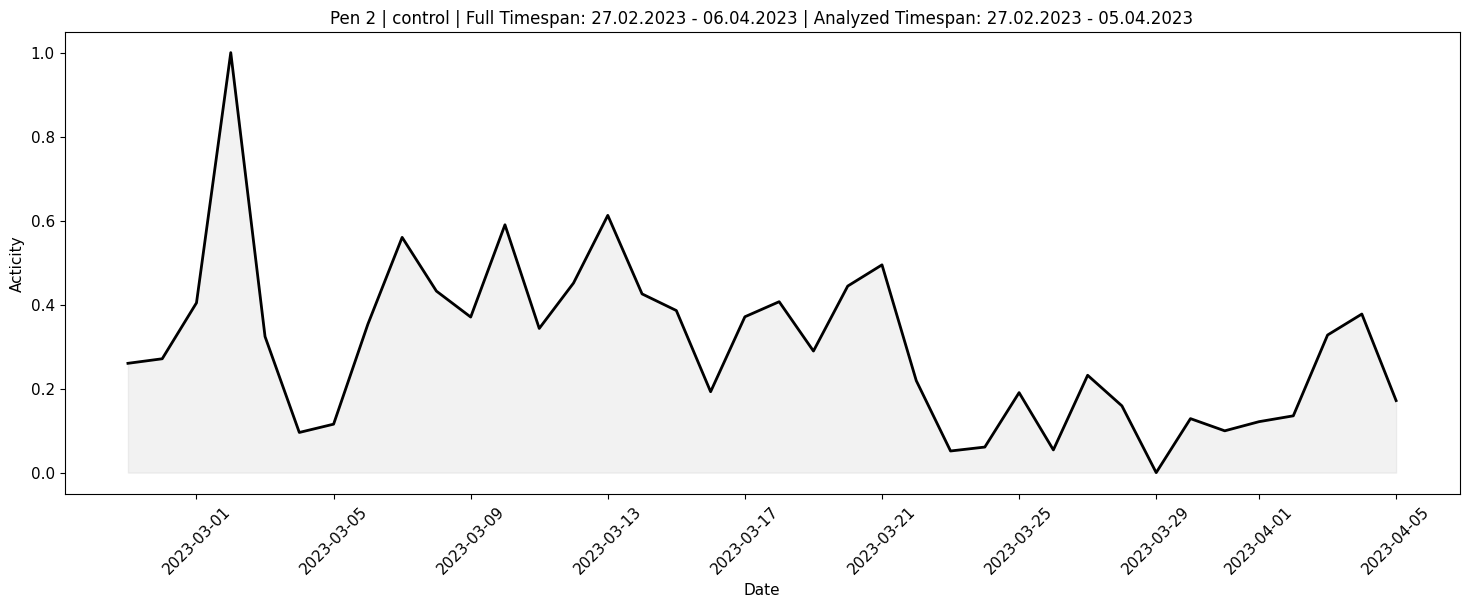

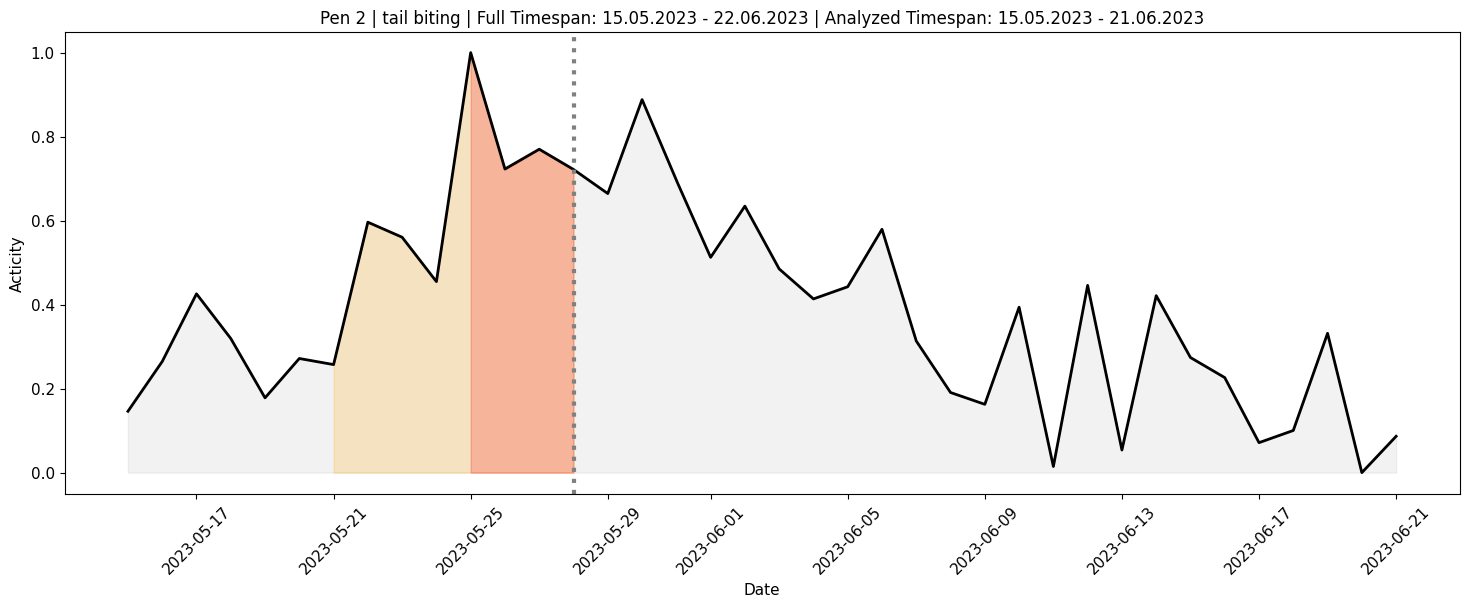

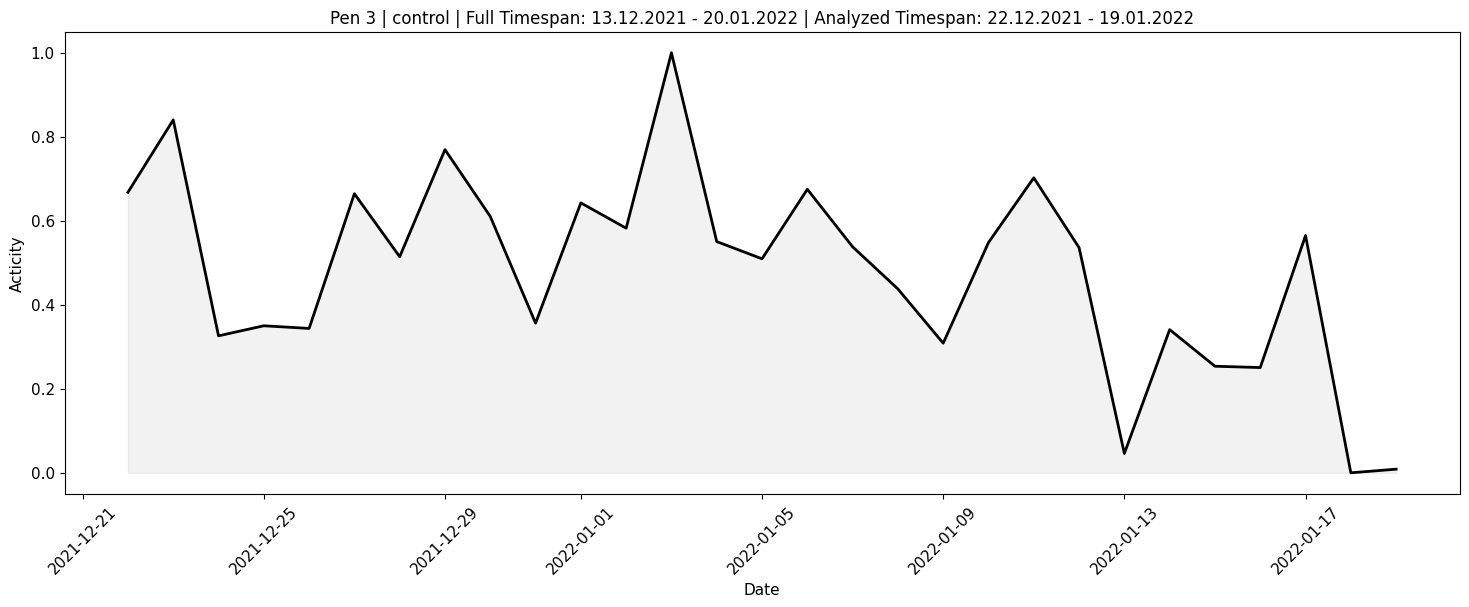

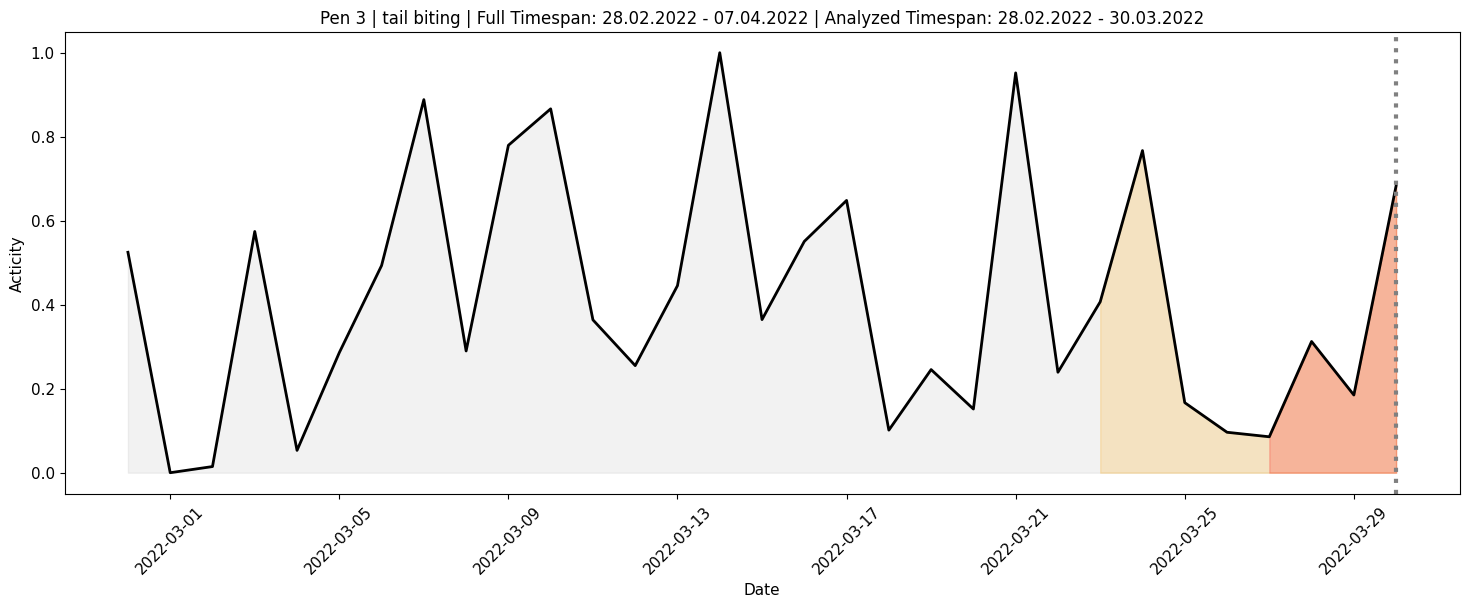

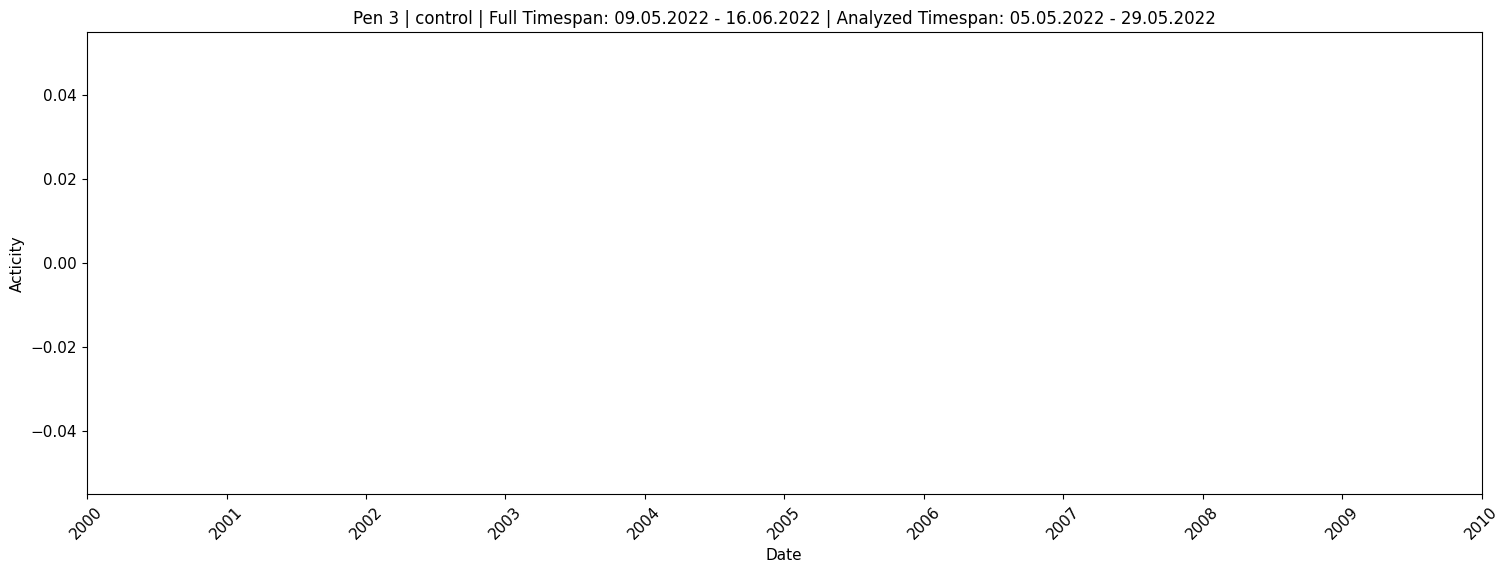

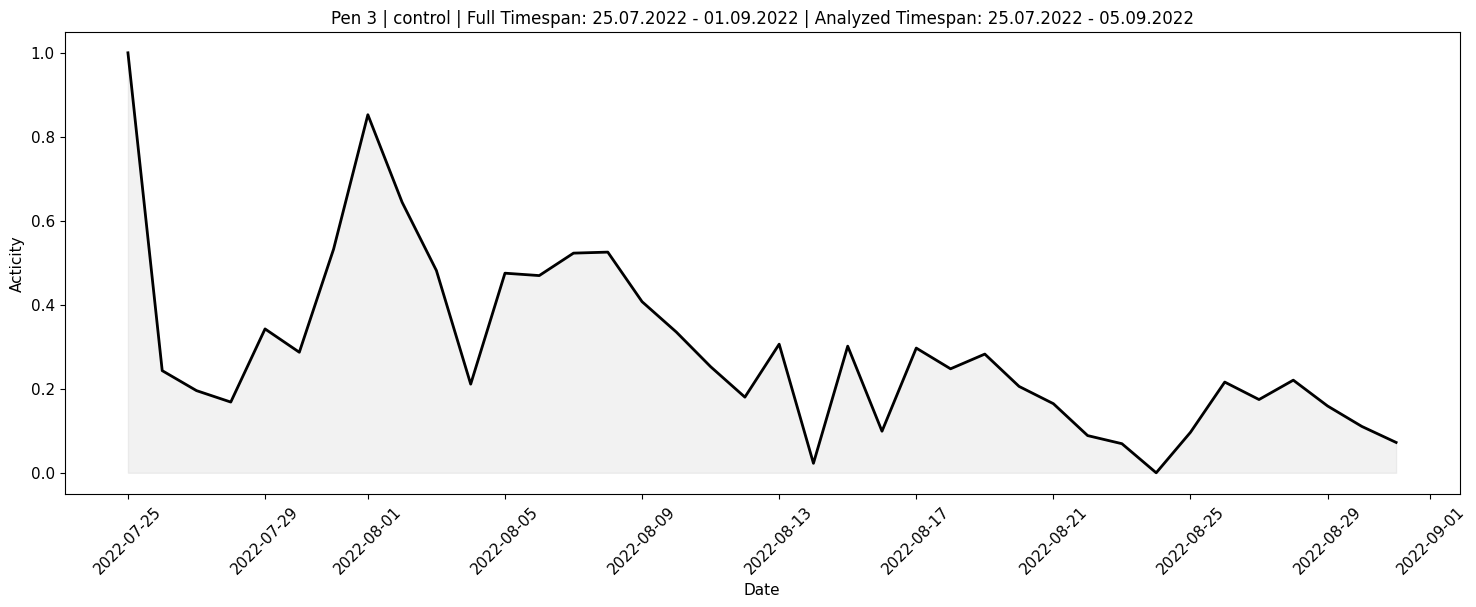

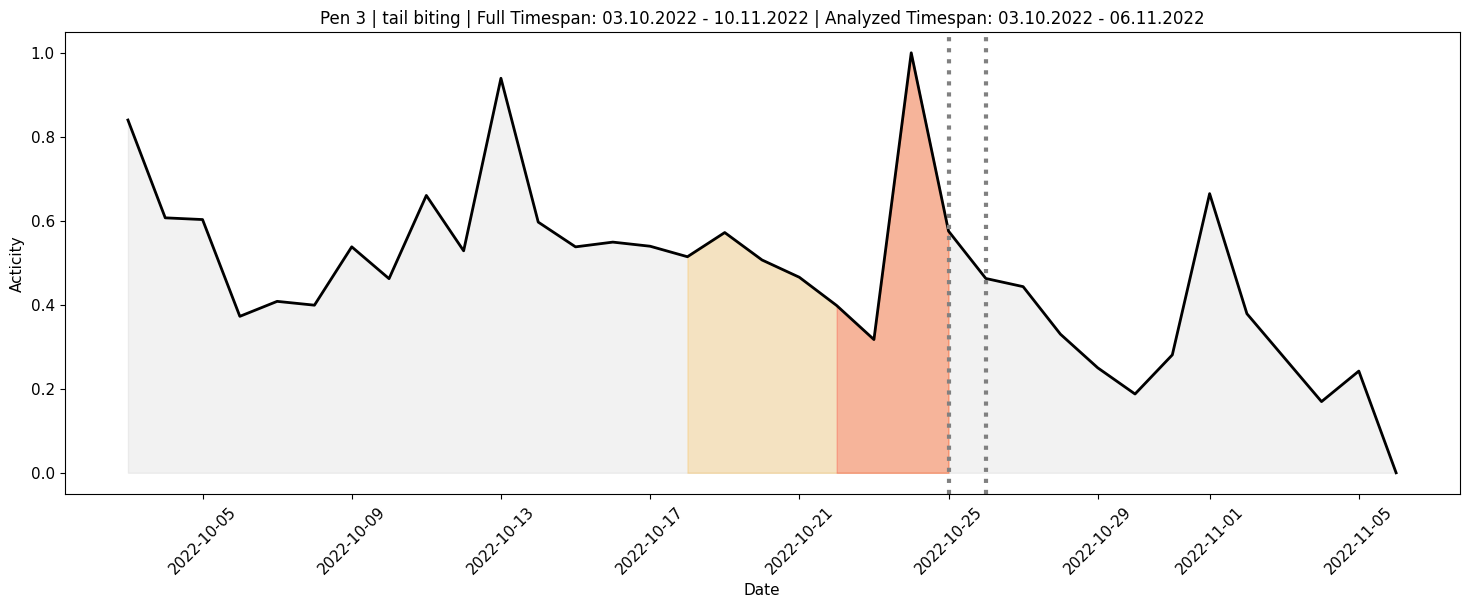

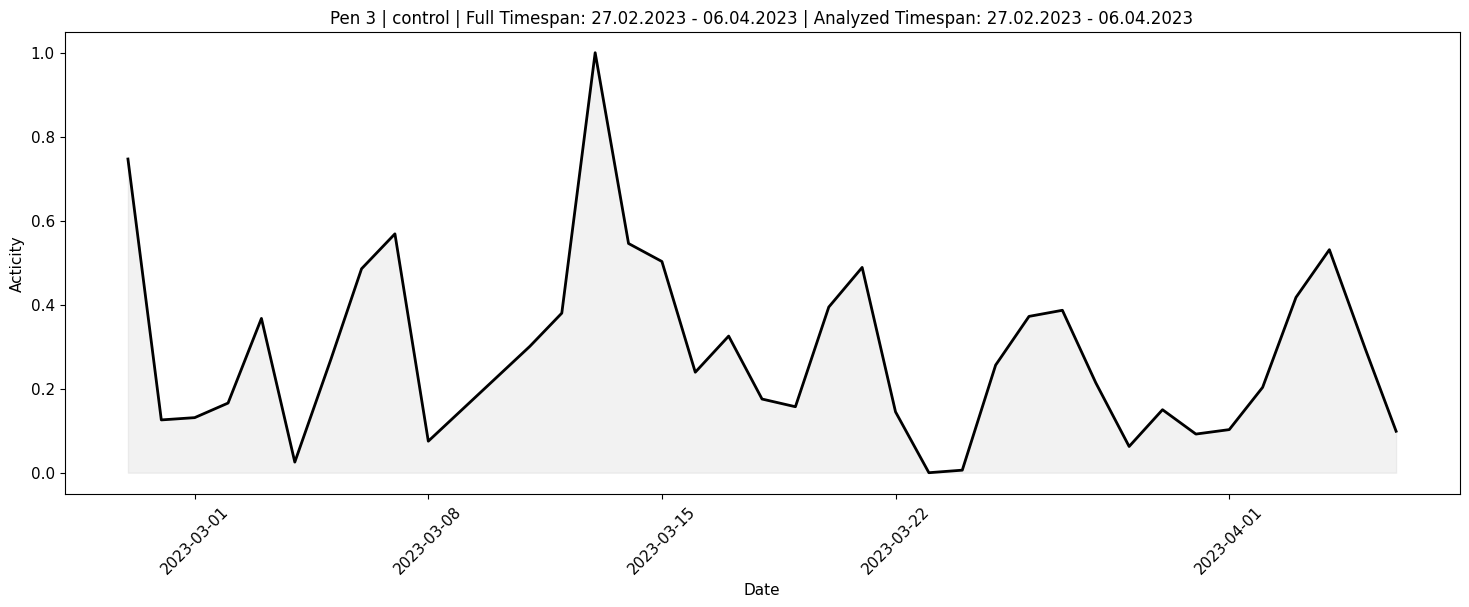

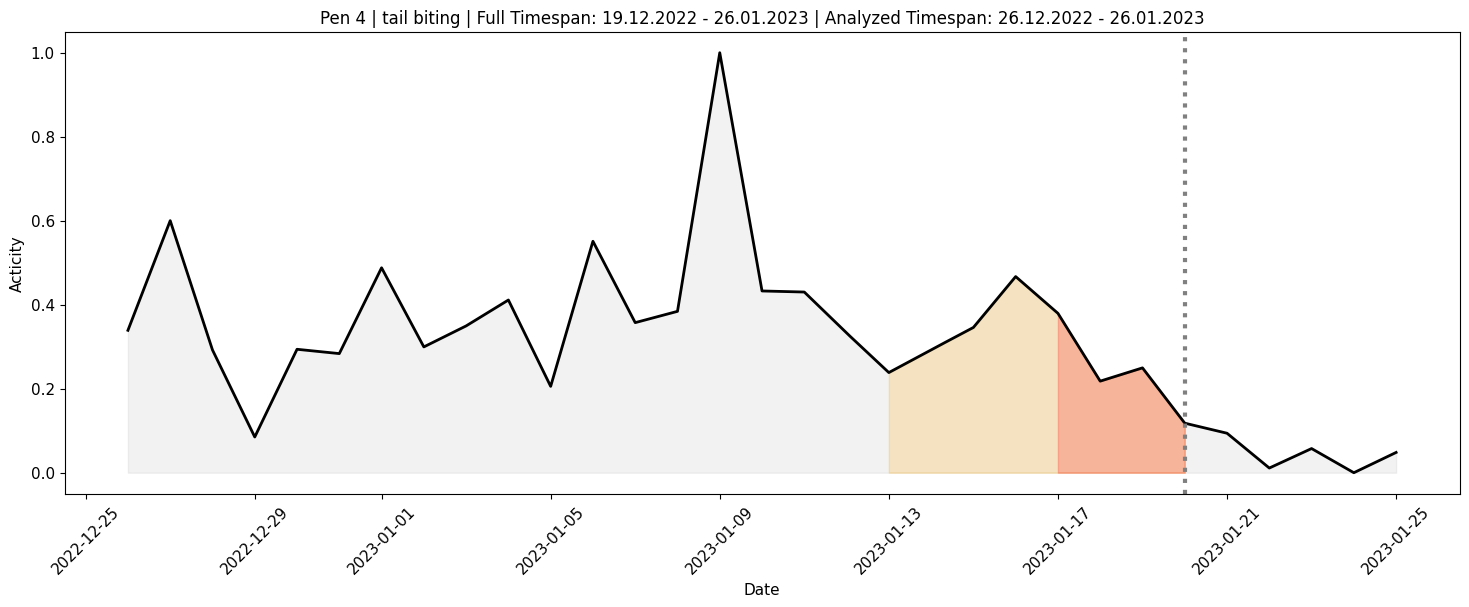

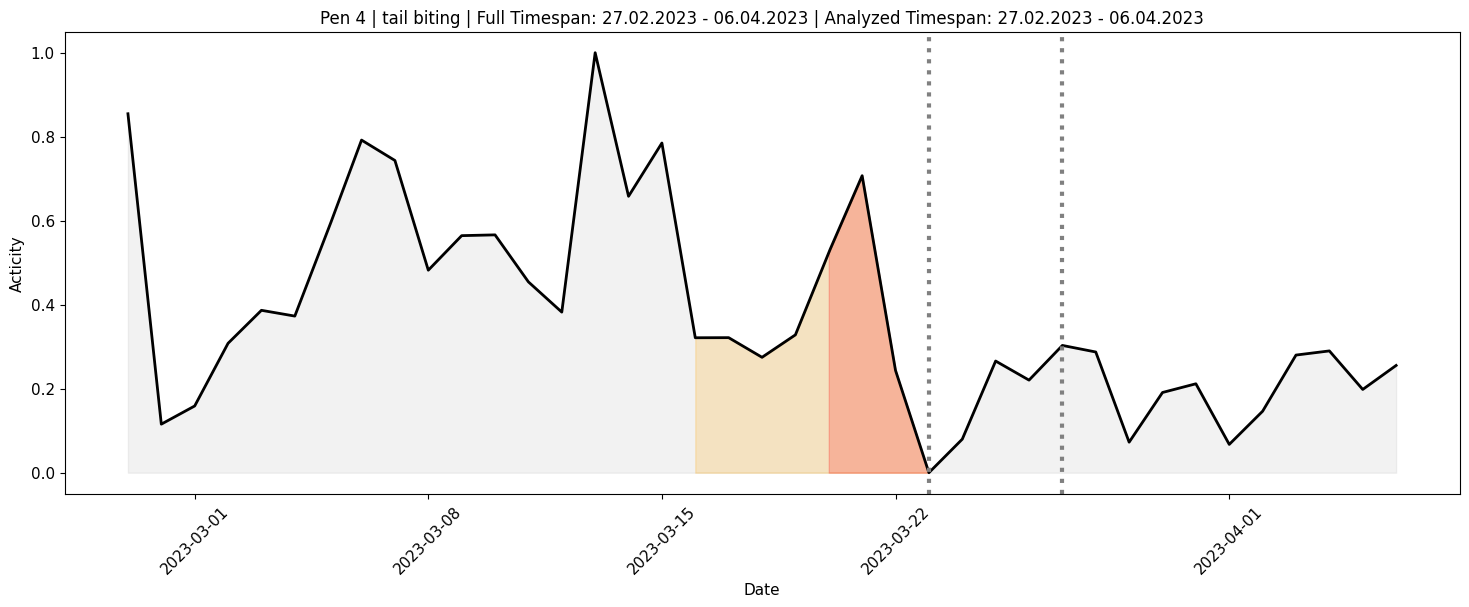

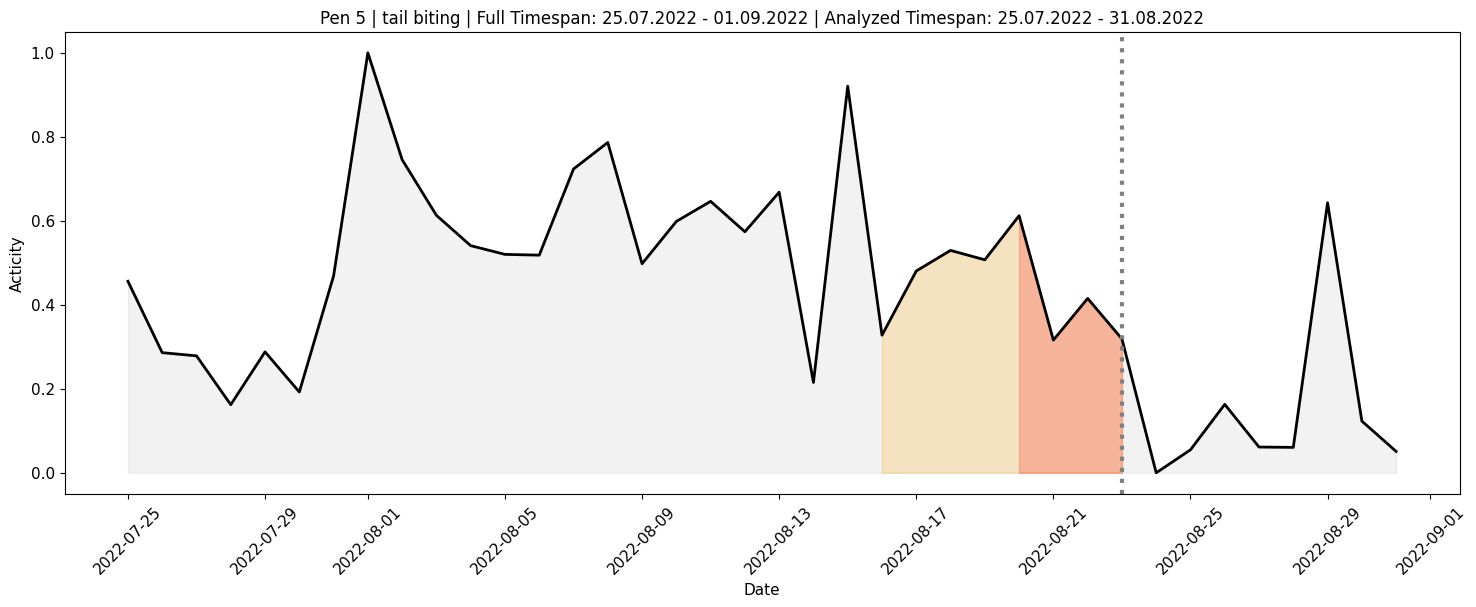

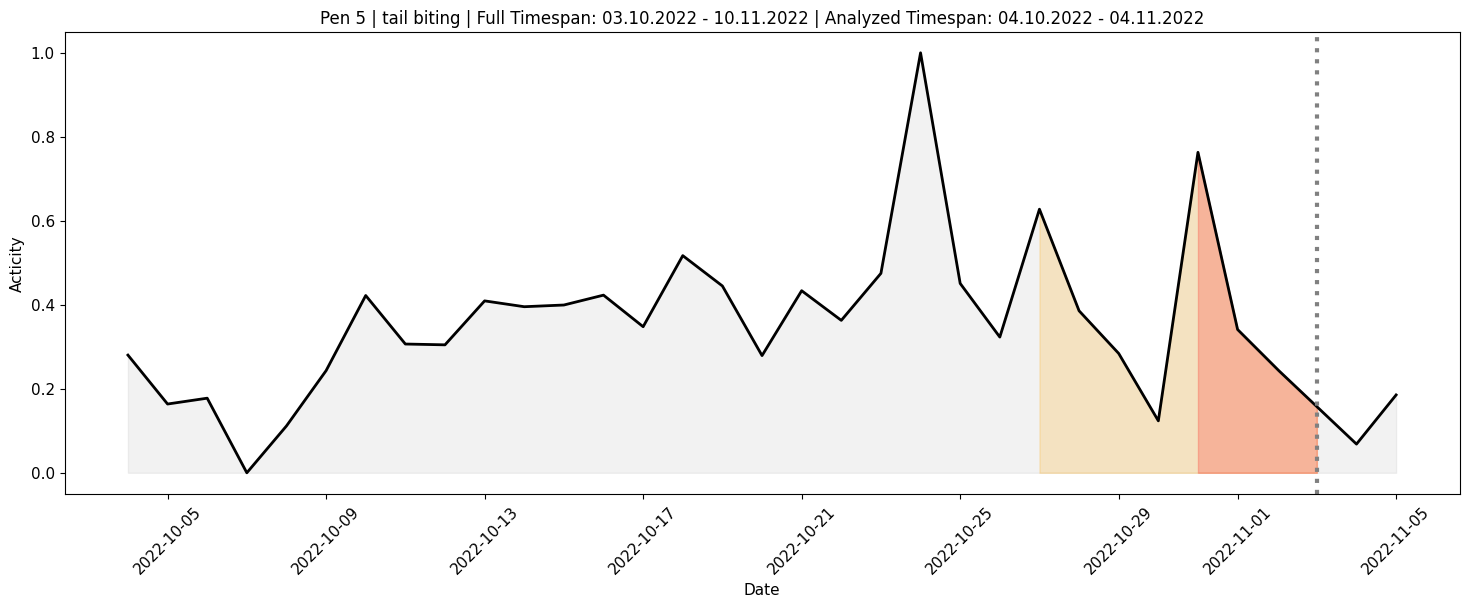

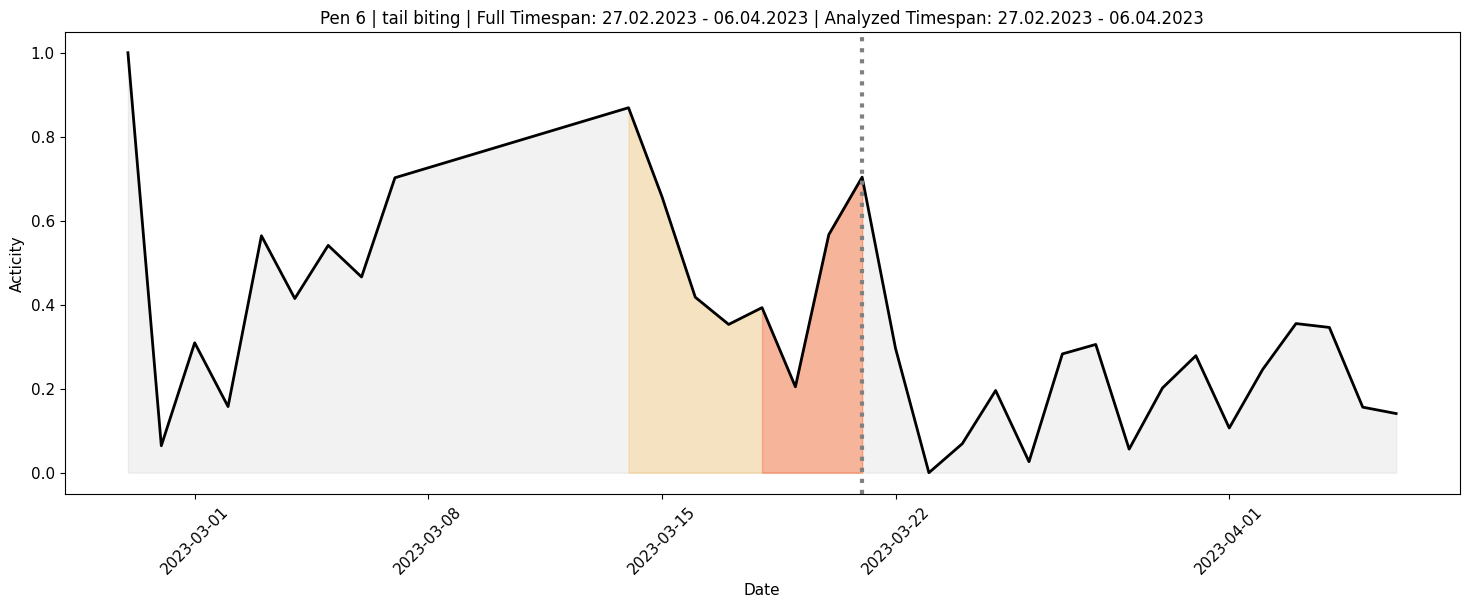

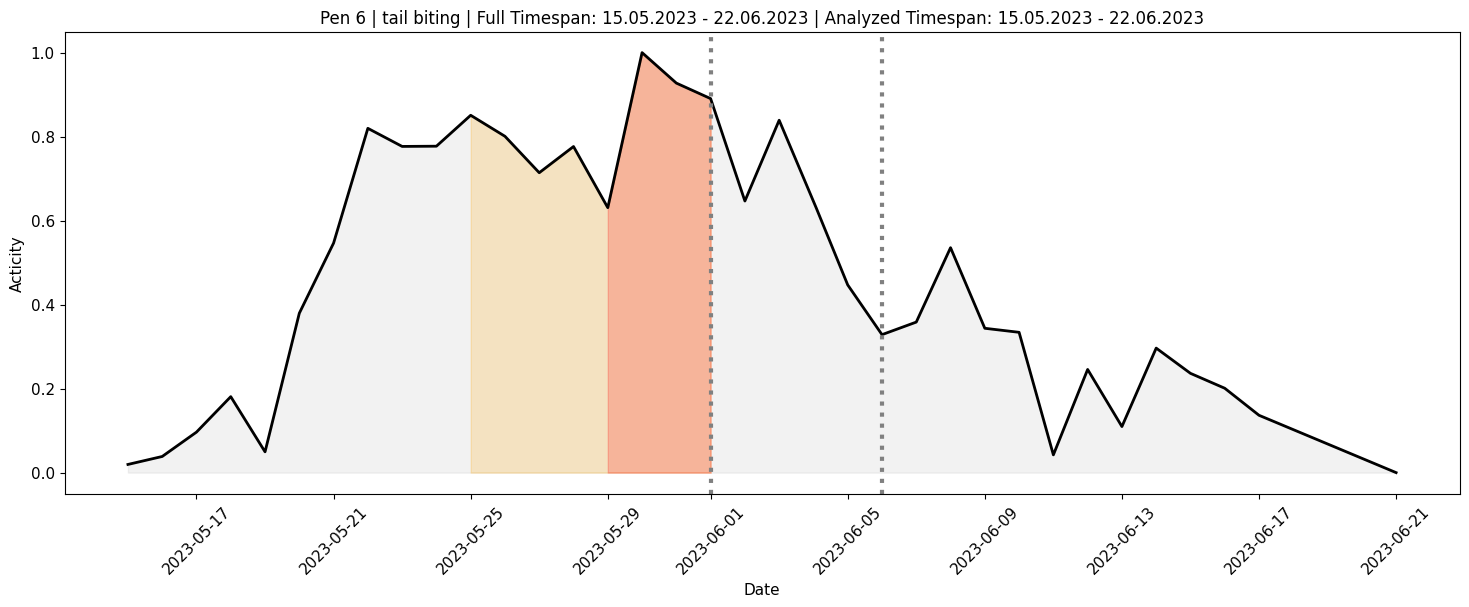

In [13]:
for el in pipeline_monitoring_results:
    analyze_activity_changes(el, path_to_piglet_rearing_info,
                                    resample_freq="D", normalize=True, rolling_window=None)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks


def plot_average_activity(dataframes_list, resample_freqs=None, days_index=None, normalize=False, rolling_window=None,
                          ewm_window=None, save_path=None, with_pig_posture=False, show_peaks=False):

    # Convert resample_freq to a more readable format for the title
    def freq_to_readable(freq):
        if freq == 'raw':
            return 'Raw Data'
        elif freq.endswith('T'):
            interval = int(freq[:-1])
            return f'{interval} min' if interval < 60 else f'{interval // 60} hour'
        else:
            return freq

    # Concatenate dataframes
    data_all = pd.concat(dataframes_list)

    # Ensure 'datetime' is a datetime type and set it as the index (if it's not already)
    data_all["datetime"] = pd.to_datetime(data_all["datetime"])
    data_all.set_index("datetime", inplace=True)

    # When resample_freqs is None, set it to ['raw'] to denote raw data plotting
    if resample_freqs is None:
        resample_freqs = ['raw']

    # Resample the data if required
    if 'raw' not in resample_freqs:
        data_all = data_all.resample(resample_freqs[0]).mean()

    # Apply rolling/moving average if specified
    if rolling_window:
        data_all = data_all.rolling(window=rolling_window).mean()

    if ewm_window:
        data_all['activity'] = data_all['activity'].ewm(span=ewm_window).mean()

    # Calculate the proportions
    if normalize:
        data_all['activity'] = (data_all['activity'] - data_all['activity'].min()) / (
            data_all['activity'].max() - data_all['activity'].min())

    # If no specific index is provided, plot all days
    if days_index is None:
        days_index = range(len(dataframes_list))

    # Select the dataframes based on the provided index AFTER all calculations are done
    selected_dataframes = [data_all[data_all.index.date ==
                                    dataframes_list[i]["datetime"].iloc[0].date()] for i in days_index]

    # Concatenate selected dataframes
    avg_data_all = pd.concat(selected_dataframes)

    # Create subplots based on the number of frequencies specified
    fig, axes = plt.subplots(nrows=len(resample_freqs),
                             ncols=1, figsize=(18, 6 * len(resample_freqs)))

    # Determine columns to plot based on with_pig_posture
    columns_to_plot = ['activity']
    if with_pig_posture:
        columns_to_plot.extend(['num_pigs_lying', 'num_pigs_notLying'])

    # If there's only one frequency, make axes an array for consistent indexing
    if len(resample_freqs) == 1:
        axes = [axes]

    # Get the unique dates for x-ticks
    # unique_dates = avg_data_all.index.normalize().unique()[::3]

    for i, freq in enumerate(resample_freqs):
        # For raw data, use the avg_data_all directly
        if freq == 'raw':
            title_freq = "Raw Activity"
            avg_data = avg_data_all.copy()
        else:
            title_freq = f"Average Activity ({freq_to_readable(freq)} intervals)"
            avg_data = avg_data_all.copy()

        # Creating a secondary y-axis if plotting with pig postures
        if with_pig_posture:
            ax2 = axes[i].twinx()
            color_idx = 0
            colors = ["green", "blue"]
        else:
            ax2 = None

        # Plotting each column
        for col in columns_to_plot:

            # If this is the 'activity' column, and show_peaks is True, identify and mark peaks
            if col == 'activity' and show_peaks:
                peaks, _ = find_peaks(avg_data[col].values, prominence=0.3)
                axes[i].plot(avg_data.index[peaks],
                             avg_data[col].iloc[peaks], 'rx')

                for peak in peaks:
                    print(
                        f"Highpoint Datetime: {avg_data.index[peak]}, Value: {avg_data[col].iloc[peak]}")

                # Plotting data on the primary y-axis
                axes[i].plot(avg_data.index, avg_data[col],
                             linewidth="5", color="black", label="activity")
            elif col == 'activity':
                axes[i].plot(avg_data.index, avg_data[col],
                             linewidth="5", color="black", label="activity")

            # Handle the posture columns
            if with_pig_posture and col in ['num_pigs_lying', 'num_pigs_notLying']:
                ax2.plot(avg_data.index, avg_data[col], label=col)
                ax2.legend(loc='upper right', fontsize=16)

        # Add titles, legends, labels, etc.
        axes[i].set_title(title_freq, fontsize=20)
        axes[i].set_xlabel('Date', fontsize=18)
        axes[i].set_ylabel('Activity Level', fontsize=16)
        if ax2:
            ax2.set_ylabel('Number of Pigs', fontsize=16)

    # Common X label for the last subplot
    axes[-1].set_xlabel('Date', fontsize=18)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()  # Ensure the plots are spaced nicely

    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')

    plt.show()

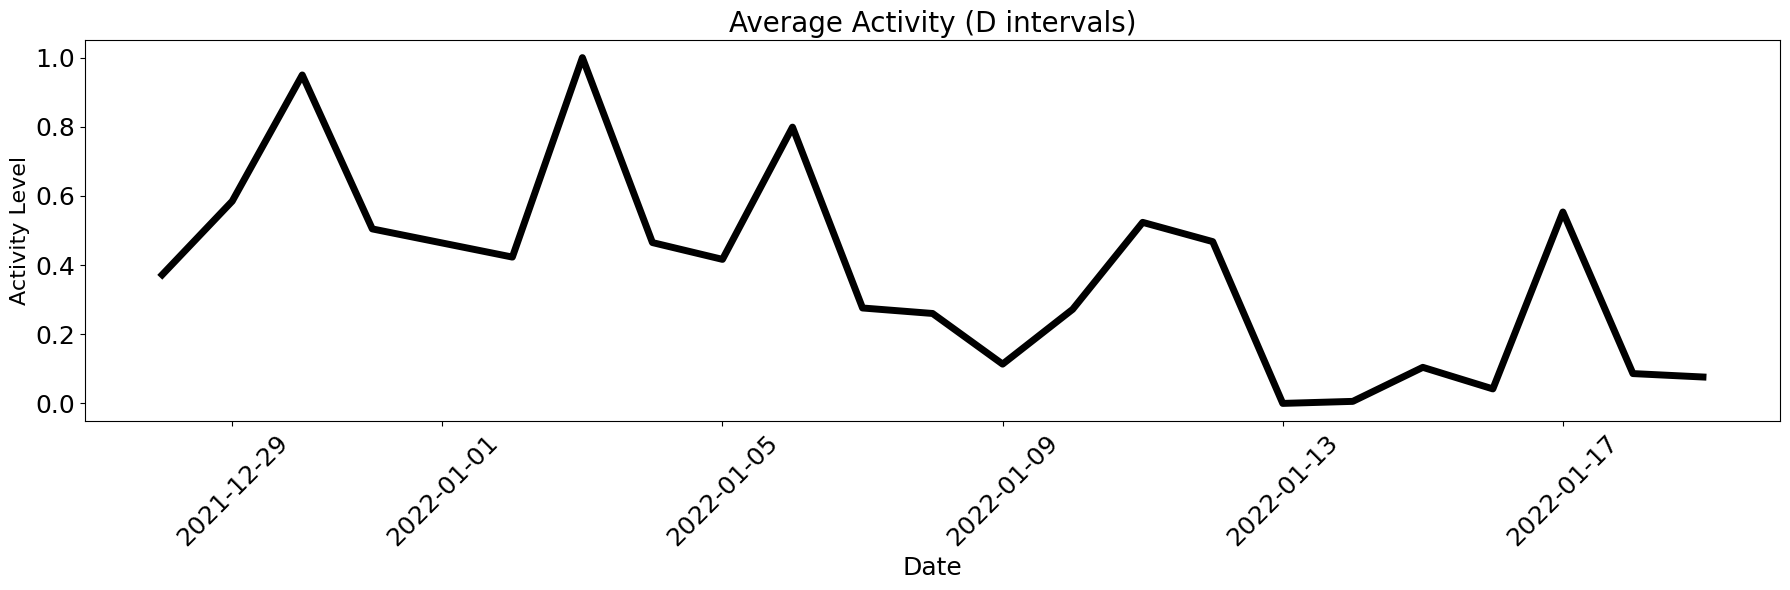

In [22]:
plot_average_activity(
            pipeline_monitoring_results[0]["dataframes"], resample_freqs=["D"], normalize=True, rolling_window=None, ewm_window=None, with_pig_posture=False)

Kamera5
2022-08-16 08:00:01
Error
Kamera1
2022-07-26 08:00:01


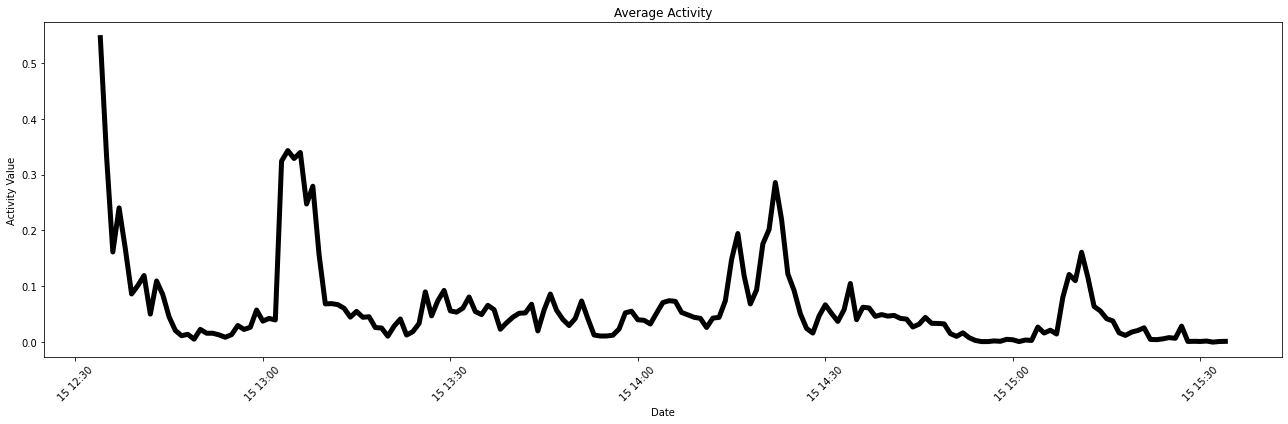

Kamera1
2022-02-28 08:00:01


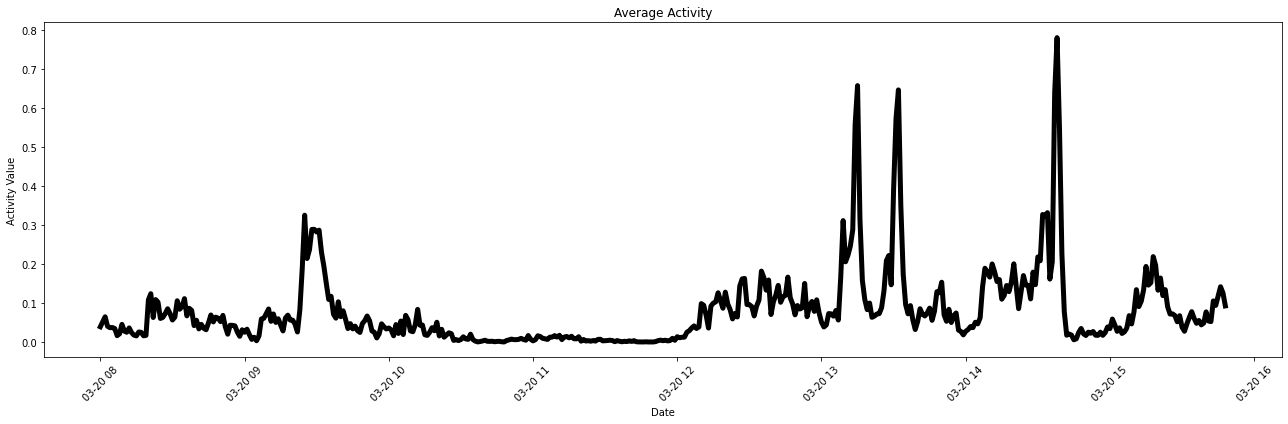

Kamera1
2023-02-27 08:00:01


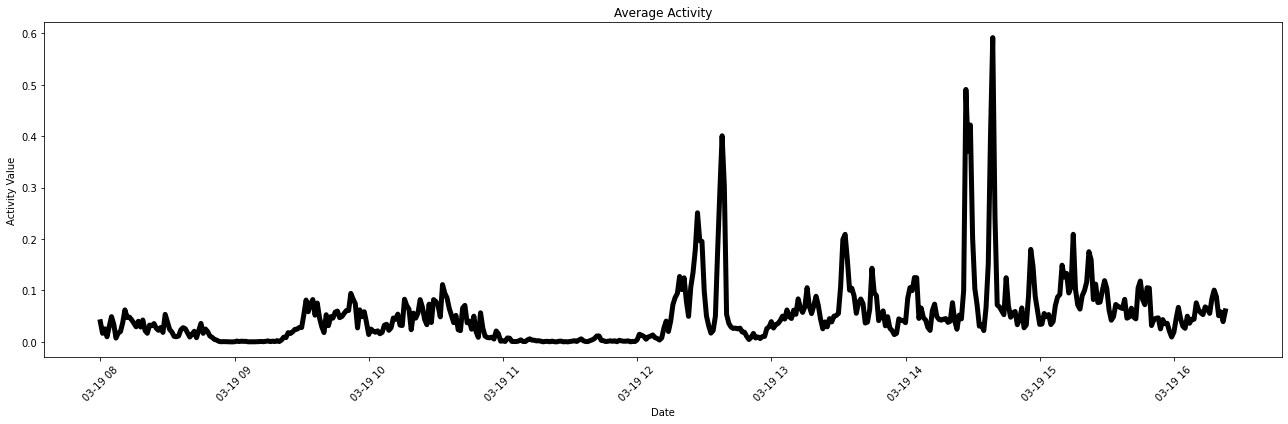

Kamera6
2023-05-15 08:00:01
Error
Kamera6
2023-02-27 08:00:01


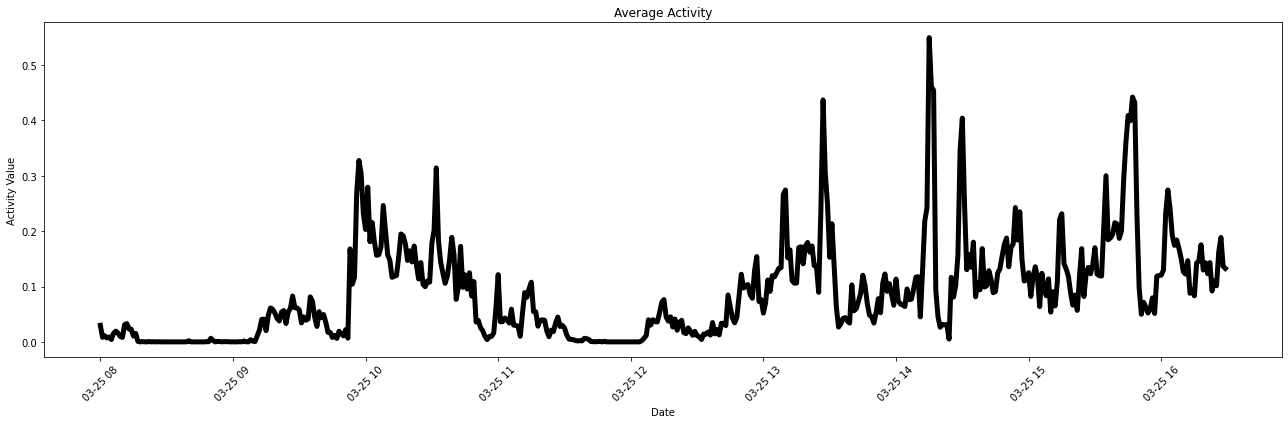

Kamera2
2023-02-27 08:00:01


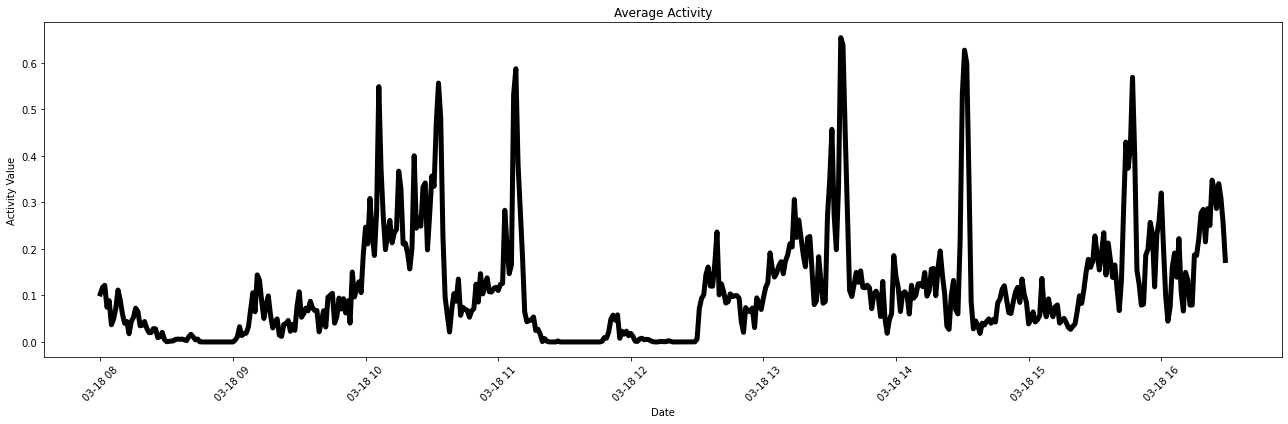

Kamera4
2023-02-27 08:00:01


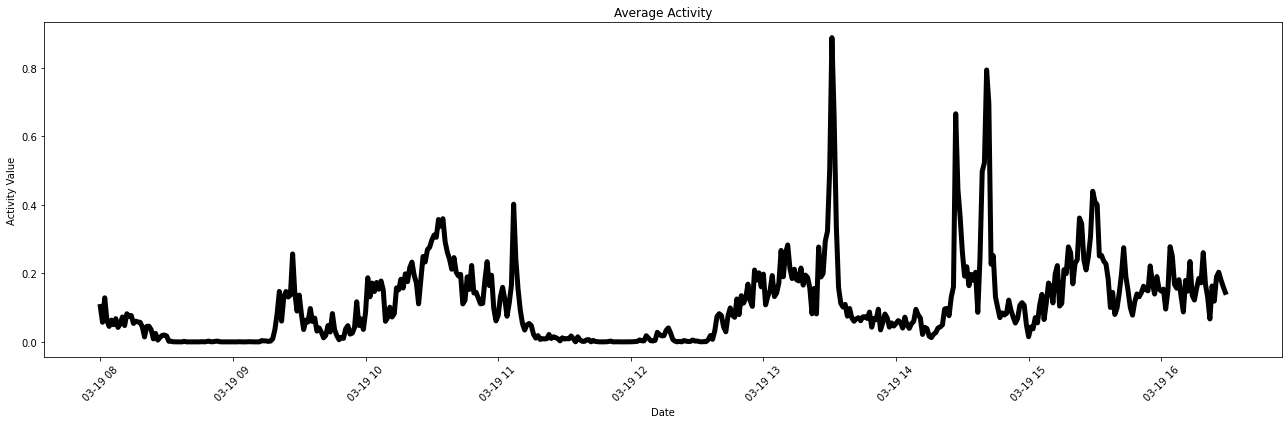

Kamera3
2022-02-28 08:00:01


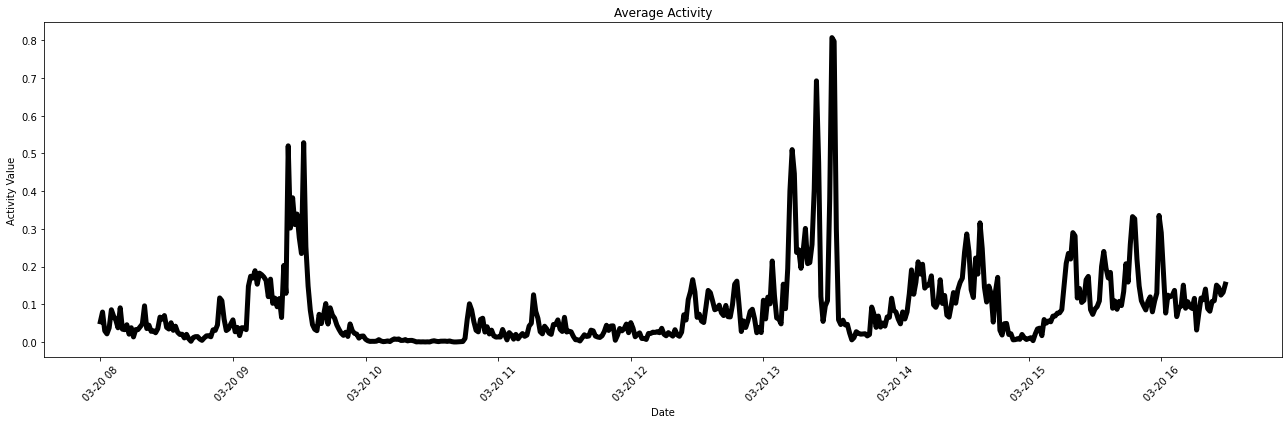

Kamera3
2023-02-27 08:00:01
Error


In [27]:
for results in pipeline_monitoring_results:
    data = results
    try:
        print(data["camera"])
        print(data["dataframes"][0].iloc[1]["datetime"])
        plot_average_activity(
            data["dataframes"], resample_freqs=["1T"], days_index=[20], normalize=True, rolling_window=None, ewm_window=None, with_pig_posture=False)
    except:
        print("Error")

In [33]:
def heatmap_average_activity(dataframes_list, resample_freq='10T', days_index=None, normalize=False,
                             rolling_window=None, ewm_window=None, save_path=None):
    """
    Plot a heatmap of average activity over specified intervals.

    Parameters:
    - dataframes_list (list of pd.DataFrame): List of dataframes, each representing a day's data.
    - resample_freq (str or None): Resampling frequency. Defaults to "10T" for 10 minutes. If None, uses raw data.
    - days_index (list of int, optional): List of indices specifying which days from the list to plot. Defaults to None, which plots all days.
    - normalize (bool): Whether to normalize activity data.
    - rolling_window (int, optional): Size of the moving average window. If provided, applies moving average smoothing to the resampled data.
    - ewm_window (int, optional): Exponential moving average window size. If provided, applies EWM to the resampled data.

    Returns:
    None. Displays a heatmap.
    """

    # If no specific index is provided, plot all days
    if days_index is None:
        days_index = range(len(dataframes_list))

    # Select the dataframes based on the provided index
    selected_dataframes = [dataframes_list[i] for i in days_index]

    # Concatenate dataframes
    data_all = pd.concat(selected_dataframes)

    # Ensure 'datetime' is a datetime type and set it as the index (if it's not already)
    data_all["datetime"] = pd.to_datetime(data_all["datetime"])
    data_all.set_index("datetime", inplace=True)

    # Resample data if a frequency is provided
    if resample_freq:
        avg_data = data_all.resample(resample_freq).mean()
    else:
        avg_data = data_all.copy()  # use raw data

    # Apply rolling/moving average if specified
    if rolling_window:
        avg_data = avg_data.rolling(window=rolling_window).mean()

    # Apply exponential moving average if specified
    if ewm_window:
        avg_data['activity'] = avg_data['activity'].ewm(span=ewm_window).mean()

    # Normalize if specified
    if normalize:
        avg_data['activity'] = (avg_data['activity'] - avg_data['activity'].min()) / (
            avg_data['activity'].max() - avg_data['activity'].min())

    # Pivot the data for heatmap
    # create a new column combining hour and minute
    avg_data['hour_minute'] = avg_data.index.strftime('%H:%M')
    avg_data['date'] = avg_data.index.date
    heatmap_data = avg_data.pivot_table(
        values='activity', index='date', columns='hour_minute')

    # Convert resample_freq to a more readable format for the title
    if resample_freq.endswith('T'):
        interval = int(resample_freq[:-1])
        if interval == 60:
            readable_freq = '1 hour'
        else:
            readable_freq = f'{interval} min'
    else:
        readable_freq = resample_freq

    # Plot heatmap
    plt.figure(figsize=(15, 6))
    ax = sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".2f",
                     cbar_kws={'label': 'Activity Level',
                               'orientation': 'vertical'},
                     annot_kws={"size": 14})  # Adjust size for annotations font inside the heatmap cells

    # Title and axis label modifications
    plt.title(
        f'Average Activity Across Days ({readable_freq} intervals)', fontsize=20)
    plt.xlabel('Time', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Date', fontsize=18)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')

    plt.show()

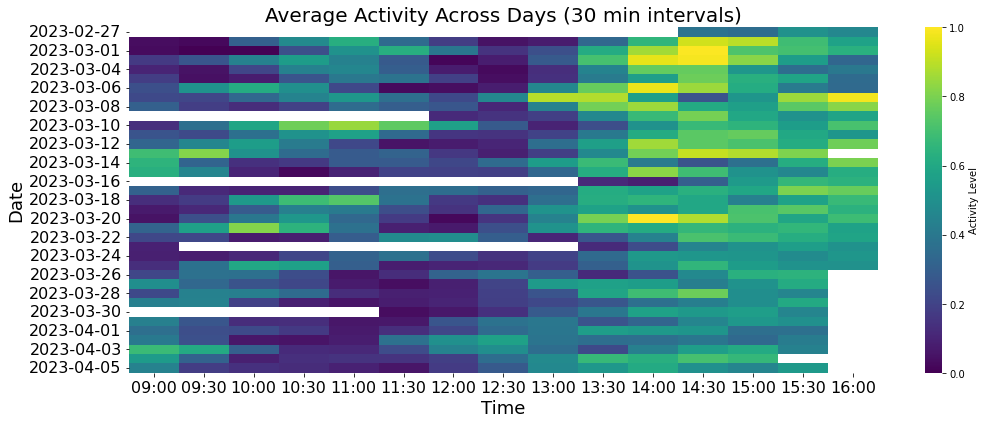

In [34]:
data = pipeline_monitoring_results[6]

# plot_average_activity(
#     data["dataframes"], resample_freqs=["1T"], days_index=[2], normalize=True, rolling_window=None, ewm_window=None, with_pig_posture=True,
#     save_path="/home/jan-hendrik/home/pipeline/outputs/graphs/avg_activity_230301_1m_with_posture.svg", show_peaks=False)
# plot_average_activity(
#     data["dataframes"], resample_freqs=["10T"], days_index=[2], normalize=True, rolling_window=None, ewm_window=None, with_pig_posture=False,
#     save_path="/home/jan-hendrik/home/pipeline/outputs/graphs/avg_activity_230301_10m.svg")
heatmap_average_activity(
    data["dataframes"], resample_freq="30T", normalize=True, rolling_window=3,
    save_path="/home/jan-hendrik/home/pipeline/outputs/graphs/activity_heatmap_230227_230405_small.svg")

In [60]:
from pipeline.utils.video_file_utils import get_time_of_video_capture

print(get_time_of_video_capture(
    "/home/jan-hendrik/home/pipeline/assets/temp/Kamera2-20230103-134857-1672750137.mp4"))

2023-01-03 12:48:58


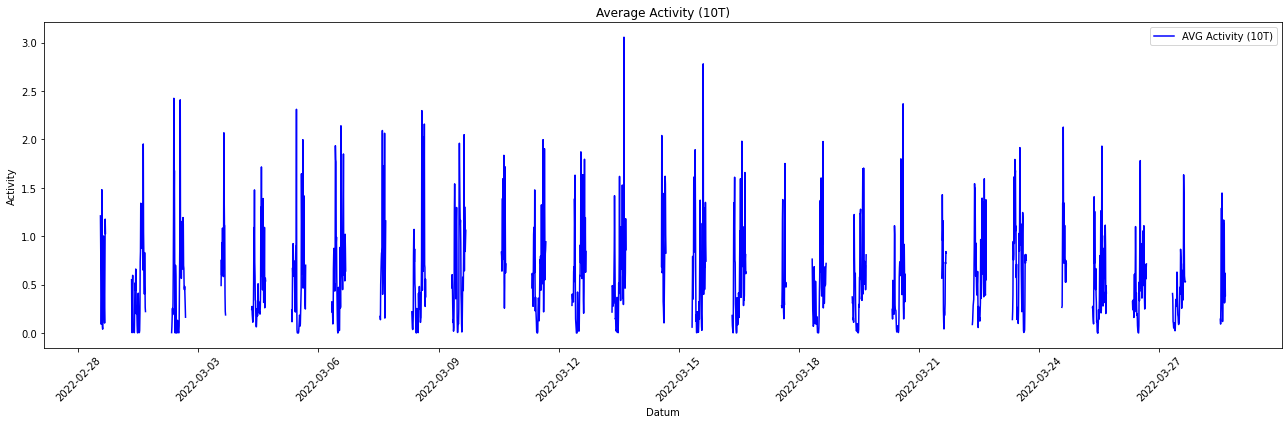

In [41]:
data = pipeline_monitoring_results[2]

plot_average_activity(
    data["dataframes"], ["10T"], days_index=None, rolling_window=0)

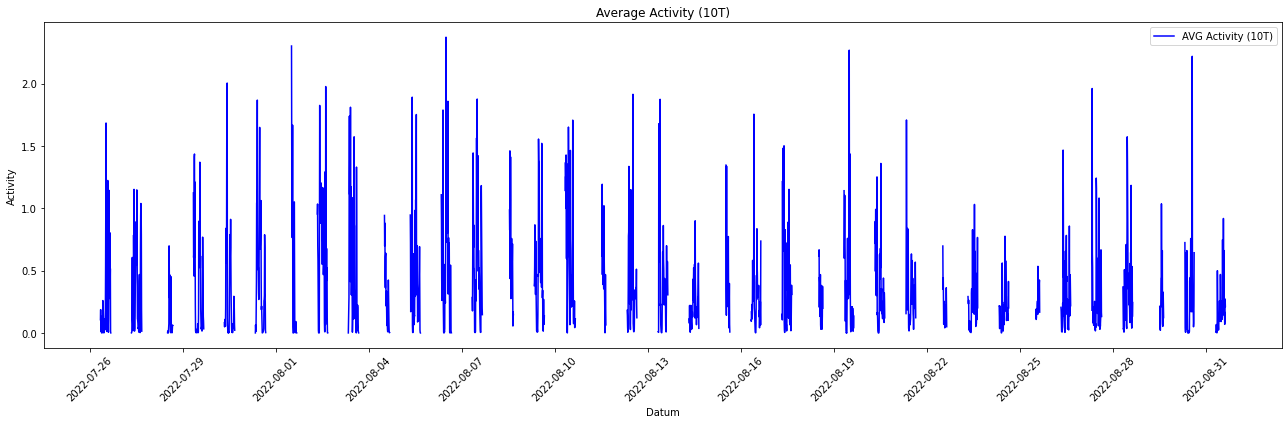

In [42]:
data = pipeline_monitoring_results[1]

plot_average_activity(
    data["dataframes"], ["10T"], days_index=None, rolling_window=0)

In [9]:
def compute_moving_avg(df, column, window_size):
    """
    Compute the moving average of a given column in the dataframe.

    :param df: Input dataframe
    :param column: Name of the column for which the moving average needs to be computed
    :param window_size: The window size for the moving average
    :return: Series containing the moving average values
    """
    return df[column].rolling(window=window_size).mean()

Kamera1


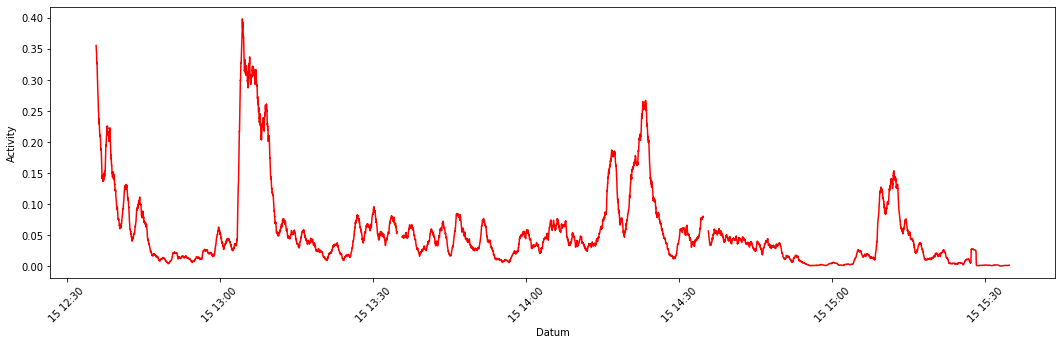

Kamera1


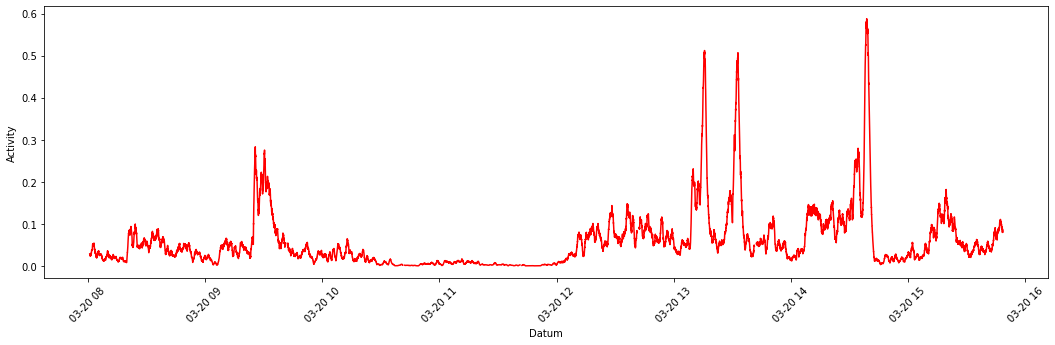

Kamera1


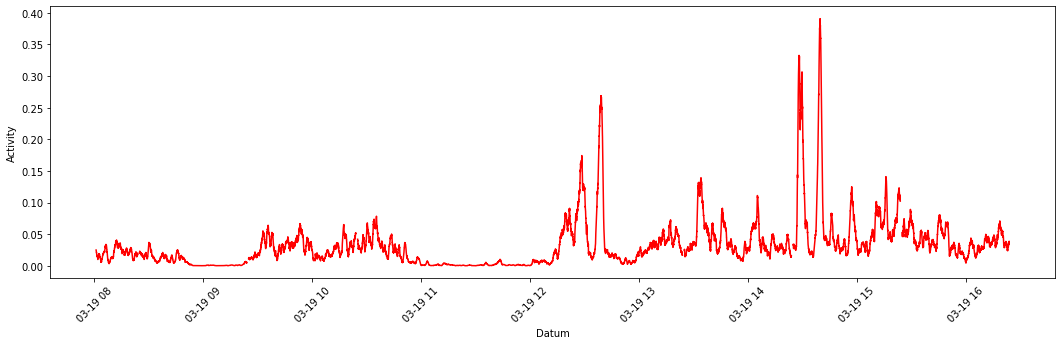

Kamera6


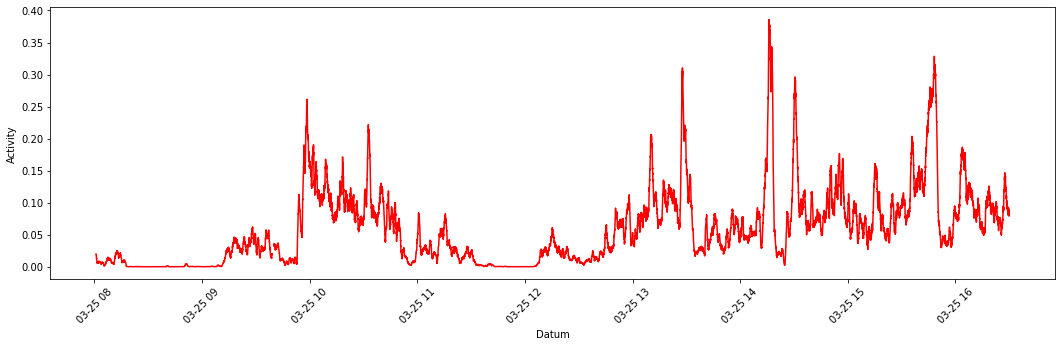

Kamera2


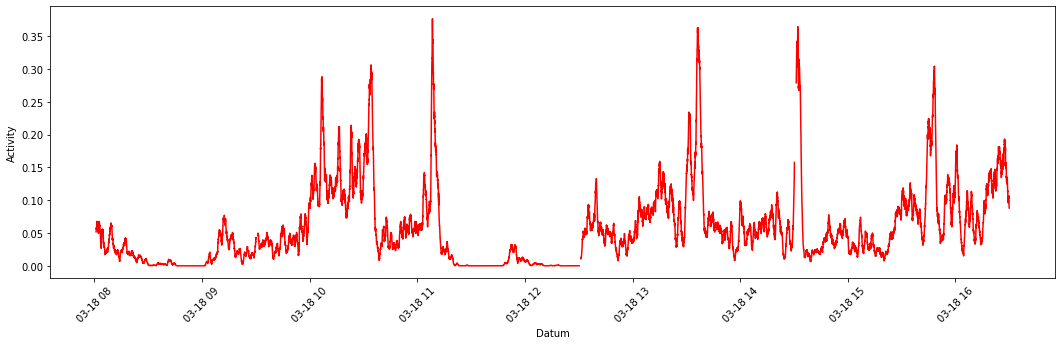

Kamera4


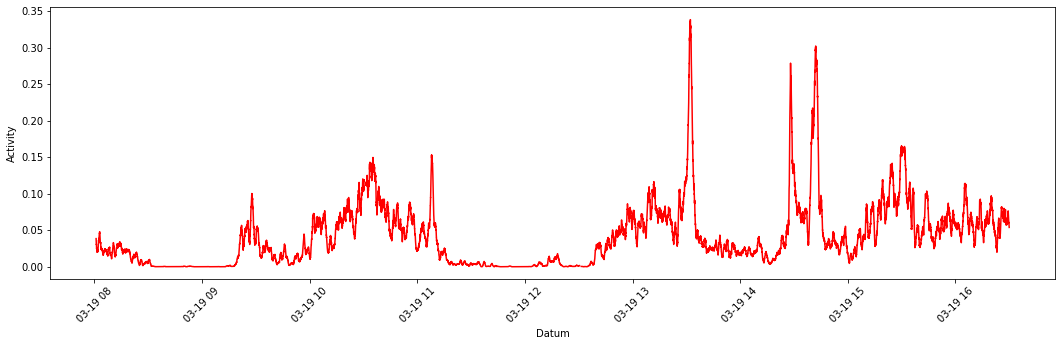

Kamera3


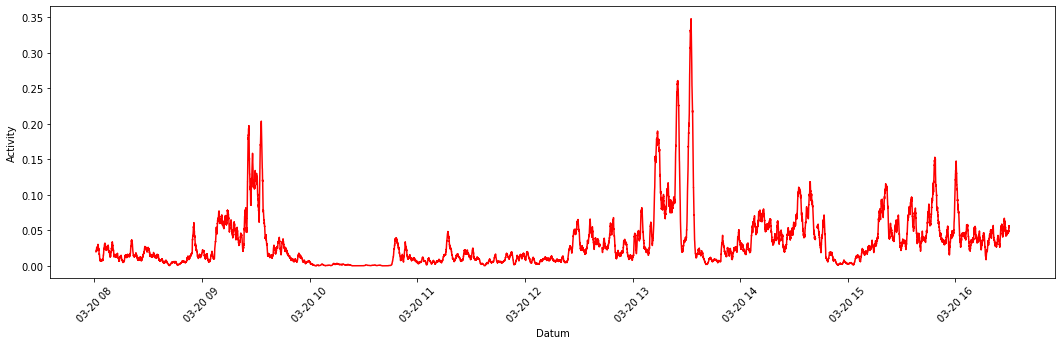

In [90]:
for results in pipeline_monitoring_results:
    try:
        data = results
        if len(data["dataframes"]) >= 15:
            print(data["camera"])
            data_day = data["dataframes"][20]
            data_day['activity'] = (data_day['activity'] - data_day['activity'].min()) / (
                data_day['activity'].max() - data_day['activity'].min())
            moving_avg_activity = compute_moving_avg(data_day, "activity", 60)
            plt.figure(figsize=(18, 5))
            plt.plot(data_day["datetime"], moving_avg_activity,
                     color="red", label='AVG lying')
            plt.xlabel('Datum')
            plt.ylabel('Activity')
            plt.xticks(rotation=45)
            plt.show()
        else:
            pass
    except:
        print("Error")